In [1]:
from constants.var_types import VAR_TYPES

from os import listdir
from os.path import isfile, join

import pickle
import numpy as np
import scipy as sp
import pandas as pd

from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

from sklearn.neighbors import DistanceMetric

from benchmark.cfg import OHConverter

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [3]:
# Custom Realistic Scores

In [4]:
def internetadv_ratio_contraint(dsName, df_oh, df_cf, df_fc, cat_feats, num_feats, model, converter):
    df_cf_found, df_fc_found = get_cleaned_processed(df_cf, df_fc, cat_feats, model, converter)
    if df_cf_found.shape[0] > 0:
        scaler = load_scaler(dsName)
        df_num_scaled = pd.DataFrame(scaler.inverse_transform(df_cf_found[['1555', '1556', '1557']]))

        output = ((df_num_scaled[1] / df_num_scaled[0]).map(lambda x: round(x, 2)) - df_num_scaled[2].map(
            lambda x: round(x, 2)) < 0.01).map(int)
        output.index = df_cf_found.index

        return output

    return np.nan

In [5]:
def pbc_multivariate_constraints(dsName, df_oh, df_cf, df_fc, cat_feats, num_feats, model, converter):
    df_cf_found, df_fc_found = get_cleaned_processed(df_cf, df_fc, cat_feats, model, converter)
    if df_cf_found.shape[0] > 0:
        scaler = load_scaler(dsName)
        cf_scaled = pd.DataFrame(scaler.inverse_transform(df_cf_found))

        x1 = (cf_scaled[2].map(lambda x: round(x, 4)) == (cf_scaled[0] * cf_scaled[1]).map(lambda x: round(x, 4))).map(
            int)

        x2 = (cf_scaled[3].map(lambda x: round(x, 3)) - (cf_scaled[1] / cf_scaled[0]).map(
            lambda x: round(x, 3)) < 0.01).map(int)

        x3 = (cf_scaled[4].map(lambda x: round(x, 3)) - (cf_scaled[7] / cf_scaled[2]).map(
            lambda x: round(x, 3)) < 0.01).map(int)

        x4 = (cf_scaled[5].map(lambda x: round(x, 3)) - (cf_scaled[8] / cf_scaled[2]).map(
            lambda x: round(x, 3)) < 0.01).map(int)

        x5 = (cf_scaled[6].map(lambda x: round(x, 3)) - (cf_scaled[7] / cf_scaled[9]).map(
            lambda x: round(x, 3)) < 0.01).map(int)

        output = (x1 + x2 + x3 + x4 + x5).map(lambda x: x == 5).map(int)
        output.index = df_cf_found.index

        return output

    return np.nan

In [6]:
def bcw_radius_area_constraint(dsName, df_oh, df_cf, df_fc, cat_feats, num_feats, model, converter):
    df_cf_found, df_fc_found = get_cleaned_processed(df_cf, df_fc, cat_feats, model, converter)
    if df_cf_found.shape[0] > 0:
        scaler = load_scaler(dsName)
        cf_scaled = pd.DataFrame(scaler.inverse_transform(df_cf_found))

        output = (cf_scaled[1] ** 2 * np.pi - cf_scaled[4] < cf_scaled[4] * 0.10).map(int)
        output.index = df_cf_found.index

        return output

    return np.nan

In [7]:
dict_functions = {
    'BCW': {'ruc': [], 'rmc': [bcw_radius_area_constraint]},
    'PBC': {'ruc': [], 'rmc': [pbc_multivariate_constraints]},
    'InternetAdv': {'ruc': [], 'rmc': [internetadv_ratio_contraint]}
}

In [8]:
# Verify if offset between the x and o classes is, at maximum 1
def tictactoe_constraint(dsName, df_oh, df_cf, df_fc, cat_feats, num_feats, model, converter):
    df_cf_found, df_fc_found = get_cleaned_processed(df_cf, df_fc, cat_feats, model, converter)
    if df_cf_found.shape[0] > 0:
        if cat_feats:

            df_ohi = check_one_hot_integrity(df_oh, df_cf, df_fc, cat_feats, num_feats, model, converter)
            df_cb = check_binary_categorical(df_oh, df_cf, df_fc, cat_feats, num_feats, model, converter)

            dfc_converted_array = []
            for idx in range(df_cf_found.shape[0]):
                if df_ohi.iloc[idx] == 1 and df_cb.iloc[idx] == 1:
                    dfc_converted_array.append(converter.convert(df_cf_found.iloc[int(idx):int(idx) + 1].to_numpy())[0])
                else:
                    dfc_converted_array.append(['x'] * df_cf_found.shape[1])
            dfc_converted = pd.DataFrame(dfc_converted_array)

            dict_ttt = {'x': 1, 'o': -1, 'b': 0}
            for col in list(dfc_converted.columns):
                dfc_converted[col] = dfc_converted[col].apply(lambda x: dict_ttt[x])

            output = dfc_converted.sum(axis=1).map(lambda x: int(x in [0, 1, -1]))
            output.index = df_cf_found.index

            return output

    return np.nan

In [9]:
# Realistic Scores

In [10]:
def check_outside_num_range(dsName, df_oh, df_cf, df_fc, cat_feats, num_feats, model, converter):
    df_cf_found, df_fc_found = get_cleaned_processed(df_cf, df_fc, cat_feats, model, converter)
    if df_cf_found.shape[0] > 0:
        if len(num_feats) > 0:
            scaler = load_scaler(dsName)
            scaled_ds = pd.DataFrame(scaler.inverse_transform(df_oh[num_feats]))

            num_feats_idx = []

            for n_f in num_feats:
                num_feats_idx.append(str(list(df_oh.columns).index(n_f)))
            scaled_cf = pd.DataFrame(scaler.inverse_transform(df_cf_found[num_feats_idx]))

            for i in range(scaled_ds.shape[1]):
                scaled_cf[i] = scaled_cf[i].map(lambda x: scaled_ds[i].min() <= x and x <= scaled_ds[i].max())

            output = scaled_cf.T.sum().map(lambda x: x == scaled_cf.shape[1]).map(int)
            output.index = df_cf_found.index

            return output
    return np.nan

In [11]:
def load_scaler(dsName):
    return pickle.load(open(f'./scalers/{dsName}.sc', 'rb'))

In [12]:
def verify_one_hot(df_oh, df_cf, df_fc, cat_feats, num_feats, model, converter):
    oh_i = check_one_hot_integrity(df_oh, df_cf, df_fc, cat_feats, num_feats, model, converter)
    oh_b = check_binary_categorical(df_oh, df_cf, df_fc, cat_feats, num_feats, model, converter)

    return (oh_i * oh_b).sum() / oh_b.shape[0]

In [13]:
def check_one_hot_integrity(df_oh, df_cf, df_fc, cat_feats, num_feats, model, converter):
    df_cf_found, df_fc_found = get_cleaned_processed(df_cf, df_fc, cat_feats, model, converter)
    bin_feats = converter.binary_cats

    if df_cf_found.shape[0] > 0:
        if len(cat_feats) > 0:
            cat_oh_feats = list(set(cat_feats) - set(bin_feats))

            if len(cat_oh_feats) > 0:
                array_cat_int = []
                for cat_oh_f in cat_oh_feats:
                    array_cat_int.append(
                        df_cf_found.iloc[:, list(converter.dict_feat_idx[cat_oh_f].values())].apply(lambda x: x > 0,
                                                                                                    axis=1).sum(
                            axis=1).map(lambda x: x == 1))

                df_cat_int = pd.concat(array_cat_int, axis=1)

                output = df_cat_int.sum(axis=1).map(lambda x: x == df_cat_int.shape[1]).map(int)
                output.index = df_cf_found.index

                return output

    return np.nan

In [14]:
def check_binary_categorical(df_oh, df_cf, df_fc, cat_feats, num_feats, model, converter):
    df_cf_found, df_fc_found = get_cleaned_processed(df_cf, df_fc, cat_feats, model, converter)

    if df_cf_found.shape[0] > 0:

        if len(cat_feats) > 0:
            num_feats_idx = [str(list(df_oh.columns).index(n_f)) for n_f in num_feats]

            cat_feats_idx = list(set(df_cf_found.columns) - set(num_feats_idx))

            factual_cat_cols = df_fc_found.loc[:, cat_feats_idx].apply(
                lambda x: x.map(lambda y: y not in [1.0, 0.0, 1, 0]), axis=1).T.sum()

            assert factual_cat_cols.sum() == 0

            output = df_cf_found.loc[:, cat_feats_idx].apply(lambda x: x.map(lambda y: y in [1.0, 0.0, 1, 0]),
                                                             axis=1).apply(sum, axis=1).map(
                lambda x: int(x == len(cat_feats_idx)))
            output.index = df_cf_found.index

            return output

    return np.nan

In [15]:
def get_bin_feats_idx(df_oh, converter):
    bin_cols = converter.binary_cats
    bin_feats = []
    for b_c in bin_cols:
        try:
            bin_feats.append(list(df_oh.columns).index(b_c))
        except ValueError:
            bin_feats.append(list(df_oh.columns).index('0'*(4-len(b_c))+b_c))
    return bin_feats

In [16]:
# General Scores

In [17]:
def md(df_oh, df_cf, df_fc, cat_feats, num_feats, model, converter):
    df_cf_found, df_fc_found = get_cleaned_processed(df_cf, df_fc, cat_feats, model, converter)

    if df_cf_found.shape[0] > 0:
        output_result = []
        for idx in range(df_cf_found.shape[0]):
            m_dis = sp.spatial.distance.mahalanobis(df_cf_found.iloc[idx].to_numpy(),
                                                    df_fc_found.drop(columns=['output']).iloc[idx].to_numpy(),
                                                    df_oh.drop(columns=['output']).cov().to_numpy())
            output_result.append(m_dis)

        out_array = output_result
        output_results = [np.nan] * df_cf.shape[0]
        for idx_result, idxFound in enumerate(list(df_fc_found.index)):
            output_results[idxFound] = out_array[idx_result]

        return output_results

    return [np.nan]*df_cf.shape[0]

In [18]:
# Mean can give misleading values because very high values on MAD
def madd(df_oh, df_cf, df_fc, cat_feats, num_feats, model, converter):
    df_cf_found, df_fc_found = get_cleaned_processed(df_cf, df_fc, cat_feats, model, converter)

    if df_cf_found.shape[0] > 0:
        df_mad = df_cf_found.iloc[:0]

        df_oh_c = df_oh.copy()
        df_oh_c.columns = df_fc_found.columns
        num_feats_idx = [str(list(df_oh.columns).index(n_f)) for n_f in num_feats]

        cat_feats_idx = list(set(df_cf_found.columns) - set(num_feats_idx))

        mad_num = {}
        for n_feat_idx in num_feats_idx:
            # 1e-8 added to avoid 0 and, then, division by zero
            mad_num[n_feat_idx] = sp.stats.median_abs_deviation(df_oh_c[n_feat_idx]) + 1e-8

            df_mad[n_feat_idx] = abs(df_cf_found[n_feat_idx] - df_fc_found[n_feat_idx]) / mad_num[n_feat_idx]

        for c_feat_idx in cat_feats_idx:
            df_mad[c_feat_idx] = (df_cf_found[c_feat_idx] != df_fc_found[c_feat_idx]).map(int)

        output_result = [0]*df_cf.shape[0]
        if len(cat_feats_idx) > 0:
            add_output_result = df_mad[cat_feats_idx].mean(axis=1)
            for null_row in list(set([*range(len(output_result))])-set(df_mad.index)):
                add_output_result.loc[null_row] = np.nan
            add_output_result = add_output_result.sort_index()
            output_result = np.add(output_result, add_output_result.tolist())
        if len(num_feats_idx) > 0:
            add_output_result = df_mad[num_feats_idx].mean(axis=1)
            for null_row in list(set([*range(len(output_result))])-set(df_mad.index)):
                add_output_result.loc[null_row] = np.nan
            add_output_result = add_output_result.sort_index()
            output_result = np.add(output_result, add_output_result.tolist())

        out_array = output_result.tolist()
        output_results = [np.nan] * df_cf.shape[0]
        for idx_result, idxFound in enumerate(list(df_fc_found.index)):
            output_results[idxFound] = out_array[idx_result]

        return output_results

    return [np.nan]*df_cf.shape[0]

In [19]:
def get_cleaned_processed(df_cf, df_fc, cat_feats, model, converter):
    df_fc_pro = get_df_fc_pro(df_cf, df_fc, cat_feats, converter)
    df_cf_c, df_fc_pro_c = get_correct(df_cf, df_fc_pro, model)

    return df_cf_c, df_fc_pro_c

In [20]:
def get_correct(df_cf, df_fc, model):
    df_cf_found, df_fc_found = remove_na(df_cf, df_fc)
    if df_cf_found.shape[0] > 0:
        labels_cf = model.predict(df_cf_found.to_numpy()).round()
        return df_cf_found[labels_cf.reshape(-1, 1) != df_fc_found['output'].to_numpy().reshape(-1, 1)], df_fc_found[
            labels_cf.reshape(-1, 1) != df_fc_found['output'].to_numpy().reshape(-1, 1)]

    return df_cf_found.iloc[:0], df_fc.iloc[:0]

In [21]:
def validity_total(df_cf, df_fc, model):
    df_cf_found, df_fc_found = remove_na(df_cf, df_fc)
    if df_cf_found.shape[0] > 0:
        
        out_array = (model.predict(df_cf_found.to_numpy()).round().reshape(1,-1)!=df_fc_found['output'].to_numpy())[0].tolist()
        output_results = [np.nan]*df_cf.shape[0]
        for idx_result, idxFound in enumerate(list(df_fc_found.index)):
            output_results[idxFound] = out_array[idx_result]

        return output_results
    return [False]*df_cf.shape[0]

In [22]:
def validity_found(df_cf, df_fc, model):
    df_cf_found, df_fc_found = remove_na(df_cf, df_fc)
    if df_cf_found.shape[0] > 0:

        out_array = (model.predict(df_cf_found.to_numpy()).round().reshape(1,-1)!=df_fc_found['output'].to_numpy())[0].tolist()
        output_results = [np.nan] * df_cf.shape[0]
        for idx_result, idxFound in enumerate(list(df_fc_found.index)):
            output_results[idxFound] = out_array[idx_result]

        return output_results
    return [False]*df_cf.shape[0]

In [23]:
def remove_na(df_cf, df_fc):
    return df_cf.dropna(), df_fc[0==df_cf.isna().sum(axis=1)]

In [24]:
def get_df_fc_pro(df_cf, df_fc, cat_feats, converter):
    array_df_fc_pro = []
    if len(cat_feats) > 0:
        for idx, row in df_fc.iterrows():
            row_fc_pro = converter.convert_to_oh(pd.DataFrame(row).T.drop(columns=['output']).to_numpy().tolist()[0])
            array_df_fc_pro.append(row_fc_pro)
        df_fc_pro = pd.DataFrame(array_df_fc_pro)
        df_fc_pro['output'] = df_fc['output']
    else:
        df_fc_pro = df_fc.copy()

    df_fc_pro.columns = list(df_cf.columns) + ['output']

    return df_fc_pro

In [25]:
def sparsity(df_cf, df_fc, cat_feats, model, converter):
    df_cf_found, df_fc_found = get_cleaned_processed(df_cf, df_fc, cat_feats, model, converter)

    if df_cf_found.shape[0] > 0:
        df_fc_found = df_fc_found.copy().drop(columns=['output'])

        scores = []
        for i in range(df_cf_found.shape[0]):
            scores.append((df_cf_found.iloc[i].round(4) == df_fc_found.iloc[i].round(4)).sum() / df_cf_found.shape[1])

        out_array = scores
        output_results = [np.nan] * df_cf.shape[0]
        for idx_result, idxFound in enumerate(list(df_fc_found.index)):
            output_results[idxFound] = out_array[idx_result]

        return output_results

    return [np.nan]*df_cf.shape[0]

In [26]:
def l2(df_cf, df_fc, cat_feats, model, converter):
    df_cf_found, df_fc_found = get_cleaned_processed(df_cf, df_fc, cat_feats, model, converter)

    if df_cf_found.shape[0] > 0:
        df_fc_found = df_fc_found.copy().drop(columns=['output'])
        scores = []
        for i in range(df_cf_found.shape[0]):
            scores.append(np.linalg.norm(
                df_cf_found.iloc[i].round(4).to_numpy().reshape(-1, 1) -
                df_fc_found.iloc[i].round(4).to_numpy().reshape(-1, 1)))

        out_array = scores
        output_results = [np.nan] * df_cf.shape[0]
        for idx_result, idxFound in enumerate(list(df_fc_found.index)):
            output_results[idxFound] = out_array[idx_result]

        return output_results

    return [np.nan]*df_cf.shape[0]

In [27]:
cat_ds = []
num_ds = []
mix_ds = []

for dsName, dsData in VAR_TYPES.items():

    if len(dsData['categorical']) > 0 and len(dsData['numerical']):
        mix_ds.append(dsName)
    elif len(dsData['categorical']) > 0:
        cat_ds.append(dsName)
    else:
        num_ds.append(dsName)

In [28]:
onlyfiles = [f for f in listdir('./cfoutput') if isfile(join('./cfoutput', f))]

In [29]:
def _nn_ohe(input_shape, hidden_layers_ws, output_number):
    x_in = Input(shape=(input_shape,))
    x = Dense(hidden_layers_ws, activation='relu')(x_in)
    x_out = Dense(2, activation='softmax')(x)
    if output_number == 1:
        x_bin = Dense(1, activation='linear')(x_out)
        nn = Model(inputs=x_in, outputs=x_bin)
    if output_number == 2:
        nn = Model(inputs=x_in, outputs=x_out)

    nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return nn

In [30]:
raw_results = [f for f in listdir('./results') if isfile(join('./results', f))]
raw_results = list(set(raw_results)-{'.init'})

In [31]:
framework_names = ['ALIBIC', 'ALIBICNOGRAD', 'CADEX', 'DICE', 'GROWINGSPHERES3', 'LORE', 'MACE', 'MLEXPLAIN', 'SEDC', 'SYNAS']

In [32]:
dsNames = np.sort(list(VAR_TYPES.keys())).tolist()

In [33]:
for fw in framework_names:
    for dsn in dsNames:
        ds_rows_0 = []
        ds_rows_1 = []
        ds_rows_time = []
        
        for rr in raw_results:
            if fw == rr.split('_')[-1].split('.')[0] and dsn == rr.split('_')[3]:
                if rr[0:4] == 'TIME':
                    ds_rows_time.append(pd.read_csv(f'./results/{rr}', header=None))
            if fw == rr.split('_')[-1].split('.')[0] and dsn == rr.split('_')[2]:
                if rr[0:4] != 'TIME':
                    ds_row = pd.read_csv(f'./results/{rr}')
                    ds_row.index = [int(rr.split('_')[1])]
                    if rr[0] == '0':
                        ds_rows_0.append(ds_row)
                    if rr[0] == '1':
                        ds_rows_1.append(ds_row)
        
        n_factual_rows_0 = pd.read_csv(f'./experiments_data/{dsn}_CFDATASET_0.csv').shape[0]
        n_factual_rows_1 = pd.read_csv(f'./experiments_data/{dsn}_CFDATASET_1.csv').shape[0]
        
        if len(ds_rows_0) > 0:
            df_test0 = pd.concat(ds_rows_0).sort_index()
            missing_rows_0 = list(set([*range(0,n_factual_rows_0)])-set(df_test0.index))
            for mr in missing_rows_0:
                df_test0.loc[mr] = [np.nan]*df_test0.shape[1]
            df_test0.to_csv(f'./results/processed/0_{dsn}_{fw}.csv', index=False)
        
        if len(ds_rows_1) > 0:
            df_test1 = pd.concat(ds_rows_1).sort_index()
            missing_rows_1 = list(set([*range(0,n_factual_rows_1)])-set(df_test1.index))
            for mr in missing_rows_1:
                df_test1.loc[mr] = [np.nan]*df_test1.shape[1]
            df_test1.to_csv(f'./results/processed/1_{dsn}_{fw}.csv', index=False)
        
        if len(ds_rows_time) > 0:
            pd.concat(ds_rows_time).set_index(keys=[0], drop=True).reset_index().to_csv(f'./results/processed/TIME_{dsn}_{fw}.csv')

In [34]:
processed_results = [f for f in listdir('./results/processed') if isfile(join('./results/processed', f))]

In [35]:
raw_results_replication = [f for f in listdir('./replication') if isfile(join('./replication', f))]
raw_results_replication = list(set(raw_results_replication)-{'.init'})
# Make a function as the same procedure must be done to results and replication
for fw in framework_names:
    for dsn in dsNames:
        ds_rows_0 = []
        ds_rows_1 = []
        ds_rows_time = []
        
        for rr in raw_results_replication:
            if fw == rr.split('_')[-1].split('.')[0] and dsn == rr.split('_')[3]:
                if rr[0:4] == 'TIME':
                    ds_rows_time.append(pd.read_csv(f'./replication/{rr}', header=None))
            if fw == rr.split('_')[-1].split('.')[0] and dsn == rr.split('_')[2]:
                if rr[0:4] != 'TIME':
                    ds_row = pd.read_csv(f'./replication/{rr}')
                    ds_row.index = [int(rr.split('_')[1])]
                    if rr[0] == '0':
                        ds_rows_0.append(ds_row)
                    if rr[0] == '1':
                        ds_rows_1.append(ds_row)
        
        n_factual_rows_0 = pd.read_csv(f'./experiments_data/{dsn}_CFDATASET_0.csv').shape[0]
        n_factual_rows_1 = pd.read_csv(f'./experiments_data/{dsn}_CFDATASET_1.csv').shape[0]
        
        if len(ds_rows_0) > 0:
            df_test0 = pd.concat(ds_rows_0).sort_index()
            missing_rows_0 = list(set([*range(0,n_factual_rows_0)])-set(df_test0.index))
            for mr in missing_rows_0:
                df_test0.loc[mr] = [np.nan]*df_test0.shape[1]
            df_test0.to_csv(f'./replication/processed/0_{dsn}_{fw}.csv', index=False)
        
        if len(ds_rows_1) > 0:
            df_test1 = pd.concat(ds_rows_1).sort_index()
            missing_rows_1 = list(set([*range(0,n_factual_rows_1)])-set(df_test1.index))
            for mr in missing_rows_1:
                df_test1.loc[mr] = [np.nan]*df_test1.shape[1]
            df_test1.to_csv(f'./replication/processed/1_{dsn}_{fw}.csv', index=False)
        
        if len(ds_rows_time) > 0:
            pd.concat(ds_rows_time).set_index(keys=[0], drop=True).reset_index().to_csv(f'./replication/processed/TIME_{dsn}_{fw}.csv')

In [36]:
processed_replication = [f for f in listdir('./replication/processed') if isfile(join('./replication/processed', f))]

In [37]:
dict_results = {}
for file in processed_results:
    if file.split('_')[0] != 'TIME':
        n = file.split('_')[0]
        if n == 'STABILITY':
            continue
        dsName = file.split('_')[1]
        framework = file.split('_')[2].split('.')[0]

        cat_feats = VAR_TYPES[dsName]['categorical']
        num_feats = VAR_TYPES[dsName]['numerical']

        model_keras = load_model(f'./models/{dsName}.h5')

        # Get architecture info and pass to our NN architecture
        input_shape = model_keras.get_weights()[0].shape[0]
        hidden_layers_ws = model_keras.get_weights()[0].shape[1]

        adapted_nn = _nn_ohe(input_shape, hidden_layers_ws, 1)
        adapted_nn.build(input_shape=input_shape)

        adapted_nn.layers[1].set_weights(model_keras.layers[0].get_weights())
        adapted_nn.layers[2].set_weights(model_keras.layers[1].get_weights())

        if n == 1:
            # If the tested class is the minority, revert output order
            second_layer_w = []
            for w_row in model_keras.layers[1].get_weights()[0]:
                second_layer_w.append(np.flip(w_row).tolist())

            second_layer_b = np.flip(model_keras.layers[1].get_weights()[1])

            second_layer = [np.array(second_layer_w, dtype=np.float32),
                            np.array(second_layer_b, dtype=np.float32)]
            adapted_nn.layers[2].set_weights(second_layer)

        adapted_nn.layers[3].set_weights(
            [np.array([[0.0], [1.0]], dtype=np.float32), np.array([0.0], dtype=np.float32)])
        
        if len(num_feats) > 0:
            df = pd.read_csv(f'./data/NORM_{dsName}.csv')
        else:
            df = pd.read_csv(f'./data/{dsName}.csv')

        if len(cat_feats) > 0 and len(num_feats) > 0:
            df_oh = pd.read_csv(f'./data/OH_NORM_{dsName}.csv')
        elif len(cat_feats) > 0:
            df_oh = pd.read_csv(f'./data/OH_{dsName}.csv')
        else:
            df_oh = pd.read_csv(f'./data/NORM_{dsName}.csv')
        
        df_cf = pd.read_csv(f'./results/processed/{n}_{dsName}_{framework}.csv')
        df_train = pd.read_csv(f'./experiments_data/{dsName}_TRAINDATASET.csv')
        df_fc = pd.read_csv(f'./experiments_data/{dsName}_CFDATASET_{n}.csv').drop(columns=['Unnamed: 0']) 
        converter = OHConverter.Converter(df, cat_feats, list(df_oh.columns))

        print(n, dsName, framework)

        scoreValidityTotal = validity_total(df_cf, df_fc, adapted_nn)
        scoreValidityFound = validity_found(df_cf, df_fc, adapted_nn)
        scoreSparsity = sparsity(df_cf, df_fc, cat_feats, adapted_nn, converter)
        scoreL2 = l2(df_cf, df_fc, cat_feats, adapted_nn, converter)
        scoreMadd = madd(df_oh, df_cf, df_fc, cat_feats, num_feats, adapted_nn, converter)
        scoreMd = md(df_oh, df_cf, df_fc, cat_feats, num_feats, adapted_nn, converter)

        df_cf_found, df_fc_found = get_cleaned_processed(df_cf, df_fc, cat_feats, adapted_nn, converter)

        ruc = []
        rmc = []

        scoreCheckBinCat = check_binary_categorical(df_oh, df_cf, df_fc, cat_feats, num_feats, adapted_nn, converter)
        if scoreCheckBinCat is not np.nan:
            ruc.append(scoreCheckBinCat)

        scoreCheckOutsideNumRange = check_outside_num_range(dsName, df_oh, df_cf, df_fc, cat_feats, num_feats, adapted_nn,
                                                            converter)
        if scoreCheckOutsideNumRange is not np.nan:
            ruc.append(scoreCheckOutsideNumRange)

        scoreCheckOneHotIntegrity = check_one_hot_integrity(df_oh, df_cf, df_fc, cat_feats, num_feats, adapted_nn, converter)
        if scoreCheckOneHotIntegrity is not np.nan:
            rmc.append(scoreCheckOneHotIntegrity)

        if dsName in list(dict_functions.keys()):
            custom_ruc_functions = dict_functions[dsName]['ruc']
            custom_rmc_functions = dict_functions[dsName]['rmc']

            for c_ruc_function in custom_ruc_functions:
                output_ruc = c_ruc_function(dsName, df_oh, df_cf, df_fc, cat_feats, num_feats, adapted_nn, converter)
                if output_ruc is not np.nan:
                    ruc.append(output_ruc)
                else:
                    assert len(ruc) == 0

            for c_rmc_function in custom_rmc_functions:
                output_rmc = c_rmc_function(dsName, df_oh, df_cf, df_fc, cat_feats, num_feats, adapted_nn, converter)
                if output_rmc is not np.nan:
                    rmc.append(output_rmc)
                else:
                    assert len(rmc) == 0

        if len(ruc) > 0:
            scoreRUC = (sum(ruc) / len(ruc) == 1).map(int).tolist()

            out_array = scoreRUC
            output_results = [np.nan] * df_cf.shape[0]
            for idx_result, idxFound in enumerate(list(df_fc_found.index)):
                output_results[idxFound] = out_array[idx_result]

            scoreRUC = output_results

        else:
            scoreRUC = [np.nan]*df_cf.shape[0]

        if len(rmc) > 0:
            scoreRMC = (sum(rmc) / len(rmc) == 1).map(int).tolist()

            out_array = scoreRMC
            output_results = [np.nan] * df_cf.shape[0]
            for idx_result, idxFound in enumerate(list(df_fc_found.index)):
                output_results[idxFound] = out_array[idx_result]

            scoreRMC = output_results

        else:
            scoreRMC = [np.nan]*df_cf.shape[0]

        if dsName not in dict_results.keys():
            dict_results[dsName] = {}

        if n not in dict_results[dsName].keys():
            dict_results[dsName][n] = []
            
        # Validity, RUC and RMC can not have NaN as value, as they are binary states ! NaN must be converted to 0
        scoreValidityTotal = [ x if x is not np.NaN else False for x in scoreValidityTotal ]
        scoreRUC = [ x if x is not np.NaN else 0 for x in scoreRUC ]
        scoreRMC = [ x if x is not np.NaN else 0 for x in scoreRMC ]
        
        result_entry = {
            'framework': framework,
            'n': n,
            'validity': scoreValidityTotal,
            'validityFound': scoreValidityFound,
            'sparsity': scoreSparsity,
            'L2': scoreL2,
            'RUC': scoreRUC,
            'RMC': scoreRMC,
            'MAD': scoreMadd,
            'MD': scoreMd
        }

        dict_results[dsName][n].append(result_entry)

1 StatlogGC SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 SDD LORE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 DefaultOfCCC MLEXPLAIN


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 SDD ALIBIC
0 BCW LORE
1 CMSC CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Ecoli ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 CarEvaluation ALIBICNOGRAD
0 SoybeanSmall SEDC
1 Lymphography SYNAS
0 StudentPerf GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 StatlogGC DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 BalanceScale ALIBIC
1 BCW CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 PBC ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 HayesRoth SEDC
0 Wine ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 HayesRoth GROWINGSPHERES3
0 MagicGT SYNAS


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 BalanceScale ALIBICNOGRAD
0 Ecoli SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 PBC LORE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Ecoli CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 HayesRoth SEDC
0 Ecoli SYNAS


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 SoybeanSmall MLEXPLAIN
1 StatlogGC CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 SoybeanSmall DICE
0 DefaultOfCCC DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Lymphography ALIBICNOGRAD
1 MagicGT CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 StatlogGC SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 CMSC SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 TicTacToe ALIBICNOGRAD
0 Lymphography ALIBIC
0 Lymphography SEDC
0 SoybeanSmall ALIBICNOGRAD
1 Chess MLEXPLAIN
1 Nursery MLEXPLAIN
1 Nursery DICE
1 Adult CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 StudentPerf SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 TicTacToe MLEXPLAIN
1 BalanceScale CADEX
0 PBC ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 MagicGT ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Wine ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 CarEvaluation LORE
0 Chess DICE
0 InternetAdv LORE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 TicTacToe SEDC
1 PBC DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Iris SYNAS


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 TicTacToe DICE
0 BCW SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 StatlogGC SYNAS


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 SDD DICE
0 StudentPerf MACE
1 DefaultOfCCC MLEXPLAIN


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 CMSC DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Ecoli ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 HayesRoth MACE
1 CMSC MACE
1 BalanceScale ALIBIC
0 BalanceScale SEDC
0 Adult GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Iris MLEXPLAIN


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Adult ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 SoybeanSmall CADEX
0 BCW MLEXPLAIN
1 SDD ALIBICNOGRAD
0 Nursery ALIBICNOGRAD
1 InternetAdv GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Chess SEDC
0 Nursery SEDC
1 MagicGT MLEXPLAIN


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 BalanceScale SYNAS
0 StatlogGC CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 DefaultOfCCC ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Iris ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 SoybeanSmall CADEX
1 BalanceScale ALIBICNOGRAD
1 Chess ALIBIC
0 CMSC SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 MagicGT ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Lymphography GROWINGSPHERES3
1 DefaultOfCCC CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Adult ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 ISOLET SEDC
1 Chess ALIBICNOGRAD
1 InternetAdv SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 CarEvaluation DICE
0 StudentPerf SYNAS


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 BalanceScale SEDC
0 SoybeanSmall SYNAS
0 StatlogGC GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 CMSC SYNAS


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Adult DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 ISOLET GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Ecoli SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 PBC SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 HayesRoth GROWINGSPHERES3
1 StudentPerf LORE
0 DefaultOfCCC SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Ecoli GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Chess SYNAS
0 StudentPerf LORE
0 StudentPerf ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Nursery MLEXPLAIN
0 Iris DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Nursery SYNAS
0 PBC CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Adult GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 BCW MACE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 DefaultOfCCC LORE
1 Iris CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 ISOLET MLEXPLAIN
0 MagicGT ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 InternetAdv DICE
0 Lymphography LORE
1 ISOLET ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Ecoli MACE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 SDD SYNAS
0 BalanceScale DICE
0 Chess LORE
0 CMSC DICE
1 Iris ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 MagicGT MACE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 BCW SYNAS


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 SDD GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Adult ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 TicTacToe MLEXPLAIN
1 Ecoli SYNAS


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Lymphography SYNAS
1 Nursery LORE
1 HayesRoth DICE
0 SDD MLEXPLAIN
1 CMSC MLEXPLAIN


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 SoybeanSmall ALIBICNOGRAD
0 Wine GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Wine ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 ISOLET SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Wine CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Adult MLEXPLAIN


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Nursery SYNAS
1 Adult MLEXPLAIN


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 SoybeanSmall LORE
1 SoybeanSmall SEDC
1 MagicGT LORE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Wine SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Nursery CADEX
0 HayesRoth MLEXPLAIN
1 TicTacToe LORE
0 TicTacToe SEDC
1 Adult DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 InternetAdv MLEXPLAIN


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Wine MLEXPLAIN


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 HayesRoth LORE
0 Lymphography MACE
0 BalanceScale MLEXPLAIN
0 SoybeanSmall ALIBIC
1 StatlogGC SYNAS


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Ecoli DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 CarEvaluation MACE
1 PBC GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Ecoli ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Nursery ALIBICNOGRAD
1 TicTacToe ALIBIC
0 StatlogGC DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Adult SYNAS


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 BalanceScale CADEX
1 ISOLET ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 BCW DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 TicTacToe GROWINGSPHERES3
0 InternetAdv GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Ecoli LORE
1 TicTacToe ALIBICNOGRAD
0 MagicGT LORE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Nursery SEDC
1 TicTacToe CADEX
1 DefaultOfCCC SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 StatlogGC LORE
1 CMSC ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 BalanceScale SYNAS
1 Ecoli ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 PBC GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 StudentPerf GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 DefaultOfCCC DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 BalanceScale LORE
1 CMSC LORE
1 HayesRoth MACE
1 MagicGT SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 CarEvaluation GROWINGSPHERES3
1 BalanceScale DICE
0 Iris LORE
1 SoybeanSmall MLEXPLAIN
1 Lymphography CADEX
1 Adult SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 InternetAdv CADEX
0 HayesRoth CADEX
0 SoybeanSmall GROWINGSPHERES3
0 Iris SYNAS


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 PBC MACE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 CarEvaluation ALIBICNOGRAD
0 MagicGT CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Adult CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 SDD DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 ISOLET ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 CarEvaluation SYNAS
0 BCW CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Nursery DICE
0 DefaultOfCCC ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 StudentPerf DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 BalanceScale LORE
1 StudentPerf MLEXPLAIN


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 SoybeanSmall ALIBIC
0 SDD SEDC
0 TicTacToe CADEX
0 Lymphography CADEX
0 ISOLET GROWINGSPHERES3
1 StudentPerf CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 PBC DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 ISOLET DICE
0 StatlogGC LORE
0 Ecoli CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 InternetAdv MLEXPLAIN


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 CarEvaluation LORE
1 CarEvaluation DICE
0 InternetAdv DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 InternetAdv ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Wine MACE
1 CarEvaluation GROWINGSPHERES3
1 HayesRoth ALIBICNOGRAD
1 Ecoli DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 CarEvaluation ALIBIC
0 BCW ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Chess CADEX
1 CMSC ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 TicTacToe SYNAS
1 BCW LORE
1 StudentPerf ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 PBC SYNAS


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 PBC SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 DefaultOfCCC CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 SDD MLEXPLAIN
0 Iris GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 MagicGT MACE
0 HayesRoth LORE
0 Ecoli MACE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 StatlogGC GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 DefaultOfCCC SYNAS


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 BCW GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Lymphography ALIBIC
1 SoybeanSmall GROWINGSPHERES3
1 SDD MACE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Lymphography LORE
1 Ecoli MLEXPLAIN
0 StatlogGC ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 StatlogGC ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Lymphography SEDC
0 CMSC GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 TicTacToe MACE
0 CMSC SYNAS


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 InternetAdv SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Nursery ALIBIC
0 Ecoli GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 SDD CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 PBC ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Wine CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 HayesRoth ALIBIC
1 Iris LORE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 MagicGT GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 BCW MLEXPLAIN
1 Chess CADEX
1 BCW SYNAS


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Wine DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Ecoli LORE
1 BCW SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Nursery GROWINGSPHERES3
1 PBC LORE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 MagicGT GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Wine SYNAS


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Iris MACE
1 Chess LORE
1 Wine MACE
0 Iris ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 PBC ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 StatlogGC MLEXPLAIN
1 SDD SYNAS
0 CMSC LORE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Chess SYNAS
1 Iris DICE
0 SDD ALIBIC
0 CarEvaluation CADEX
0 Iris SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 PBC MACE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 HayesRoth DICE
1 PBC MLEXPLAIN


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Wine ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 SoybeanSmall SYNAS
1 Iris ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Nursery LORE
1 TicTacToe SYNAS
1 Chess GROWINGSPHERES3
1 SoybeanSmall LORE
1 CarEvaluation CADEX
1 DefaultOfCCC GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Wine MLEXPLAIN


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 MagicGT DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Chess DICE
1 StudentPerf ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 MagicGT SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Lymphography DICE
1 Lymphography DICE
0 Chess MACE
1 TicTacToe MACE
1 InternetAdv LORE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 BCW GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 PBC CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 HayesRoth MLEXPLAIN
0 SDD ALIBICNOGRAD
1 TicTacToe DICE
0 Ecoli MLEXPLAIN
0 CarEvaluation MLEXPLAIN
0 Adult ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 StudentPerf SYNAS


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 DefaultOfCCC SYNAS


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 CarEvaluation SYNAS
1 CMSC GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Lymphography MLEXPLAIN
0 SDD GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 CarEvaluation SEDC
0 SoybeanSmall DICE
0 Adult SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Iris CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 SDD SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Nursery ALIBIC
0 CMSC ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 PBC SYNAS


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Nursery CADEX
1 ISOLET MLEXPLAIN


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 HayesRoth ALIBIC
0 TicTacToe ALIBIC
1 InternetAdv ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 BalanceScale MLEXPLAIN
1 StudentPerf DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Adult LORE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 BCW ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 BCW DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Wine SYNAS


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 HayesRoth ALIBICNOGRAD
0 MagicGT ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Chess ALIBICNOGRAD
1 Lymphography GROWINGSPHERES3
1 StatlogGC ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Chess ALIBIC
0 CarEvaluation SEDC
1 MagicGT SYNAS


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 CarEvaluation MLEXPLAIN
0 DefaultOfCCC GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Wine LORE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 BalanceScale GROWINGSPHERES3
0 Nursery GROWINGSPHERES3
0 Adult SYNAS


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 MagicGT MLEXPLAIN


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 CMSC ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Lymphography MLEXPLAIN
1 TicTacToe GROWINGSPHERES3
0 ISOLET DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Wine DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 BCW ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 BCW ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Adult LORE
1 Iris MACE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 CarEvaluation ALIBIC
1 StudentPerf SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 HayesRoth CADEX
1 HayesRoth SYNAS
1 Wine SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 BalanceScale MACE
0 Nursery MACE
0 ISOLET CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Wine GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Iris GROWINGSPHERES3


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Iris MLEXPLAIN


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 DefaultOfCCC ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 PBC MLEXPLAIN


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 StatlogGC MLEXPLAIN
0 InternetAdv CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Chess SEDC
1 ISOLET LORE
0 Chess GROWINGSPHERES3
0 BalanceScale GROWINGSPHERES3
1 Iris SEDC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 BalanceScale MACE
0 SDD LORE
1 Lymphography ALIBICNOGRAD
0 CMSC MLEXPLAIN


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 Wine LORE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 CarEvaluation MACE
1 ISOLET CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 DefaultOfCCC LORE
0 StatlogGC ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


1 MagicGT DICE


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 CMSC CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 StudentPerf ALIBICNOGRAD


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 Chess MLEXPLAIN
1 Nursery MACE
0 StudentPerf CADEX
0 StudentPerf MLEXPLAIN


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 TicTacToe LORE
1 DefaultOfCCC ALIBIC


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 HayesRoth SYNAS
1 SDD CADEX


/home/rmazzine/anaconda3/envs/CF_Analysis/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [38]:
all_results = []
for ds in dsNames:
    for n in ['0', '1']:
        ds_results = []
        n_rows = 0
        for dsr in dict_results[ds][n]:
            sdf = pd.DataFrame(dsr)
            sdf['dataset'] = ds
            ds_results.append(sdf)
            
            if n_rows == 0:
                n_rows = sdf.shape[0]
            else:
                assert n_rows == sdf.shape[0]
        
        ds_f = pd.concat(ds_results)
        
        afw = list(ds_f['framework'].unique())
        
        for fw in list(set(framework_names) - set(afw)):
            adf = pd.DataFrame({'framework':[fw]*n_rows, 'n': [n]*n_rows, 'validity': [False]*n_rows, 
             'validityFound': [False]*n_rows, 'sparsity': [np.nan]*n_rows, 'L2': [np.nan]*n_rows, 
             'RUC': [np.nan]*n_rows, 'RMC': [np.nan]*n_rows, 'MAD': [np.nan]*n_rows, 'MD': [np.nan]*n_rows,
             'dataset': [ds]*n_rows})
            
            ds_results.append(adf)
            
        ds_f = pd.concat(ds_results)
        
        all_results.append(ds_f)
        
df_all_results = pd.concat(all_results)
df_all_results = df_all_results.reset_index()

In [39]:
df_all_results[['framework', 'validity']].groupby('framework').sum()

,validity
framework,
ALIBIC,1902
ALIBICNOGRAD,2474
CADEX,3549
DICE,2251
GROWINGSPHERES3,3370
LORE,1297
MACE,1302
MLEXPLAIN,933
SEDC,2461


In [40]:
## Statistical Constants
cvnt001 = { 2: 2.576, 3: 2.913, 4: 3.113, 5: 3.255, 6: 3.364, 7: 3.452, 8: 3.526, 9: 3.590, 10: 3.646, 11: 3.696,
            12: 3.741, 13: 3.781, 14: 3.818, 15: 3.853, 16: 3.884, 17: 3.914, 18: 3.941, 19: 3.967, 20: 3.992,
            21: 4.015, 22: 4.037, 23: 4.057, 24: 4.077, 25: 4.096, 26: 4.114, 27: 4.132, 28: 4.148, 29: 4.164,
            30: 4.179, 31: 4.194, 32: 4.208, 33: 4.222, 34: 4.236, 35: 4.249, 36: 4.261, 37: 4.273, 38: 4.285,
            39: 4.296, 40: 4.307, 41: 4.318, 42: 4.329, 43: 4.339, 44: 4.349, 45: 4.359, 46: 4.368, 47: 4.378,
            48: 4.387, 49: 4.395, 50: 4.404, }

cvnt005 = { 2: 1.960, 3: 2.344, 4: 2.569, 5: 2.728, 6: 2.850, 7: 2.948, 8: 3.031, 9: 3.102, 10: 3.164, 11: 3.219,
            12: 3.268, 13: 3.313, 14: 3.354, 15: 3.391, 16: 3.426, 17: 3.458, 18: 3.489, 19: 3.517, 20: 3.544,
            21: 3.569, 22: 3.593, 23: 3.616, 24: 3.637, 25: 3.658, 26: 3.678, 27: 3.696, 28: 3.714, 29: 3.732,
            30: 3.749, 31: 3.765, 32: 3.780, 33: 3.795, 34: 3.810, 35: 3.824, 36: 3.837, 37: 3.850, 38: 3.863,
            39: 3.876, 40: 3.888, 41: 3.899, 42: 3.911, 43: 3.922, 44: 3.933, 45: 3.943, 46: 3.954, 47: 3.964,
            48: 3.973, 49: 3.983, 50: 3.992, }

cvnt010 = { 2: 1.645, 3: 2.052, 4: 2.291, 5: 2.460, 6: 2.589, 7: 2.693, 8: 2.780, 9: 2.855, 10: 2.920, 11: 2.978,
            12: 3.030, 13: 3.077, 14: 3.120, 15: 3.159, 16: 3.196, 17: 3.230, 18: 3.261, 19: 3.291, 20: 3.319,
            21: 3.346, 22: 3.371, 23: 3.394, 24: 3.417, 25: 3.439, 26: 3.459, 27: 3.479, 28: 3.498, 29: 3.516,
            30: 3.533, 31: 3.550, 32: 3.567, 33: 3.582, 34: 3.597, 35: 3.612, 36: 3.626, 37: 3.640, 38: 3.653,
            39: 3.666, 40: 3.679, 41: 3.691, 42: 3.703, 43: 3.714, 44: 3.726, 45: 3.737, 46: 3.747, 47: 3.758,
            48: 3.768, 49: 3.778, 50: 3.788, }

In [41]:
## Overall Characteristics of Datasets
ds_characteristics = pd.read_excel('model_performance_analysis.xlsx').drop(columns=['Unnamed: 0'])

In [42]:
## Calculate ratio informatiom

In [43]:
# Generate data to inform majority and minority

def balance(seq):
    from collections import Counter
    from numpy import log
    
    n = len(seq)
    classes = [(clas,float(count)) for clas,count in Counter(seq).items()]
    k = len(classes)
    
    H = -sum([ (count/n) * log((count/n)) for clas,count in classes]) #shannon entropy
    return H/log(k)

ratio_data = []
for dsn in dsNames:
    df_train = pd.read_csv(f'./experiments_data/{dsn}_TRAINDATASET.csv')
    r_0 = (df_train['output']==0).sum()/df_train['output'].shape[0]
    r_1 = (df_train['output']==1).sum()/df_train['output'].shape[0]
    
    bs = balance(df_train['output'].tolist())
    
    ratio_data.append([dsn, r_0, r_1,  r_0 if r_0 > r_1 else r_1, bs])
ratio_df = pd.DataFrame(ratio_data, columns=['dataset', 'r0', 'r1', 'major_ratio', 'balance_score'])

In [44]:
ratio_df['ratio_class'] = ratio_df['major_ratio'].apply(lambda x : 'b' if x < 0.65 else 'u' if x < 0.85 else 'hu')

In [45]:
## Calculate ratio informatiom

In [46]:
df_all_results[df_all_results['framework']=='GROWINGSPHERES4']

,index,framework,n,validity,validityFound,sparsity,L2,RUC,RMC,MAD,MD,dataset


In [47]:
cat_ds

['BalanceScale',
 'CarEvaluation',
 'HayesRoth',
 'Chess',
 'Lymphography',
 'Nursery',
 'SoybeanSmall',
 'TicTacToe']

In [48]:
dft2 = ds_f.reset_index()

In [49]:
dft2[dft2['index']==0]

,index,framework,n,validity,validityFound,sparsity,L2,RUC,RMC,MAD,MD,dataset
0,0,ALIBICNOGRAD,1,True,True,0.384615,0.886054,1,0,0.235911,1.238547,Wine
70,0,ALIBIC,1,True,True,0.000000,1.026813,1,0,0.288941,1.472224,Wine
140,0,CADEX,1,True,True,0.000000,0.937665,1,0,0.386215,1.314903,Wine
210,0,SYNAS,1,False,NaN,NaN,NaN,0,0,NaN,NaN,Wine
280,0,MACE,1,False,False,NaN,NaN,0,0,NaN,NaN,Wine
350,0,MLEXPLAIN,1,False,False,NaN,NaN,0,0,NaN,NaN,Wine
420,0,DICE,1,True,True,0.000000,2.852092,1,0,0.997441,4.190930,Wine
490,0,SEDC,1,True,True,0.846154,1.629794,1,0,0.223895,2.027971,Wine
560,0,GROWINGSPHERES3,1,True,True,0.307692,0.971045,1,0,0.283913,1.140080,Wine
630,0,LORE,1,True,True,0.846154,3.061069,1,0,0.540470,3.380876,Wine


In [50]:
dft = df_all_results[(df_all_results['dataset']=='Adult')&(df_all_results['n']=='1')]

In [51]:
dft[dft['index']==0].set_index('framework').drop(columns=['index', 'n', 'validityFound', 'dataset']).T.rank(na_option='bottom')

framework,CADEX,ALIBICNOGRAD,GROWINGSPHERES3,ALIBIC,MLEXPLAIN,DICE,SYNAS,SEDC,LORE,MACE
validity,3.0,3.5,6.0,2.0,2.0,4.0,3.5,5.5,2.0,1.0
sparsity,1.0,2.0,5.0,5.5,5.5,3.0,2.0,4.0,5.5,4.5
L2,6.0,5.0,4.0,5.5,5.5,6.0,5.0,7.0,5.5,4.5
RUC,3.0,1.0,1.5,2.0,2.0,1.5,1.0,1.0,2.0,4.5
RMC,3.0,3.5,1.5,2.0,2.0,1.5,3.5,5.5,2.0,4.5
MAD,7.0,7.0,7.0,5.5,5.5,7.0,7.0,2.0,5.5,4.5
MD,5.0,6.0,3.0,5.5,5.5,5.0,6.0,3.0,5.5,4.5


In [52]:
## Numerical Analysis

In [53]:
short_frameworks = {
    'ALIBIC': 'AL',
    'ALIBICNOGRAD': 'ALN',
    'CADEX': 'CA',
    'DICE': 'DI',
    'GROWINGSPHERES3': 'GS',
    'LORE': 'LO',
    'MACE': 'MA',
    'MLEXPLAIN': 'ML',
    'SEDC': 'SE',
    'SYNAS': 'SY'
}

In [54]:
def show_values_on_bars(axs, values, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p, value_row in zip(ax.patches, values):
                _x = p.get_x() + p.get_width() + 0.02
                _y = p.get_y() + p.get_height()*0.7
                value = round(value_row, 2)
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [55]:
validity_analysis_total.groupby('framework').mean()

NameError: name 'validity_analysis_total' is not defined

In [103]:
# Total
validity_analysis_total = df_all_results[['framework', 'validity']].copy()
validity_analysis_total.columns = ['framework', 'coverage']
validity_analysis_total['coverage'] = validity_analysis_total['coverage'].fillna(False)

In [104]:
# Calculate mean
validity_analysis_total_mean = validity_analysis_total.groupby('framework').mean()
validity_analysis_total_mean = validity_analysis_total_mean.reset_index()
validity_analysis_total_mean['framework'] = validity_analysis_total_mean['framework'].map(short_frameworks)

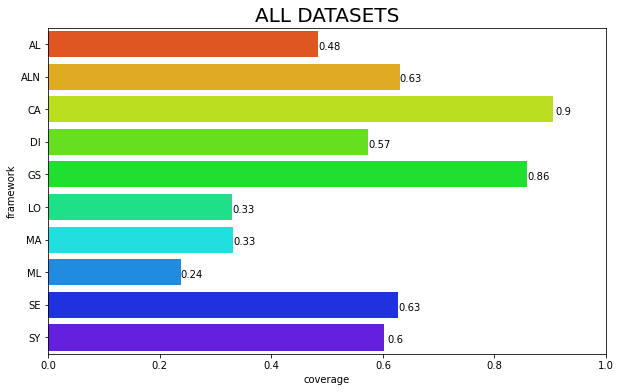

In [105]:
ax = sns.barplot(x = "coverage", y = "framework", data = validity_analysis_total_mean, palette=sns.color_palette("gist_rainbow", 11))
show_values_on_bars(ax, validity_analysis_total_mean['coverage'].tolist())
ax.set_title('ALL DATASETS', fontsize=20)
ax.set_xlim(0,1)
ax.figure.set_size_inches(10,6)

In [59]:
# Numerical
validity_analysis_num = df_all_results[df_all_results['dataset'].isin(num_ds)][['framework', 'validity']].copy()
validity_analysis_num['validity'] = validity_analysis_num['validity'].fillna(False)

In [60]:
# Calculate mean
validity_analysis_num_mean = validity_analysis_num.groupby('framework').mean()
validity_analysis_num_mean = validity_analysis_num_mean.reset_index()
validity_analysis_num_mean['framework'] = validity_analysis_num_mean['framework'].map(short_frameworks)

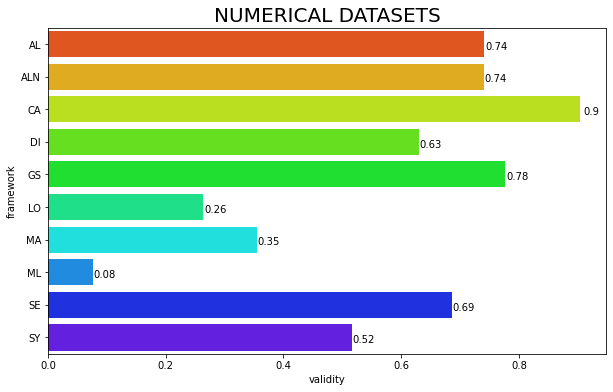

In [61]:
ax = sns.barplot(x = "validity", y = "framework", data = validity_analysis_num_mean, palette=sns.color_palette("gist_rainbow", 11))
show_values_on_bars(ax, validity_analysis_num_mean['validity'].tolist())
ax.set_title('NUMERICAL DATASETS', fontsize=20)
ax.figure.set_size_inches(10,6)

In [62]:
# Categorical
validity_analysis_cat = df_all_results[df_all_results['dataset'].isin(cat_ds)][['framework', 'validity']].copy()
validity_analysis_cat['validity'] = validity_analysis_cat['validity'].fillna(False)

In [63]:
# Calculate mean
validity_analysis_cat_mean = validity_analysis_cat.groupby('framework').mean()
validity_analysis_cat_mean = validity_analysis_cat_mean.reset_index()
validity_analysis_cat_mean['framework'] = validity_analysis_cat_mean['framework'].map(short_frameworks)

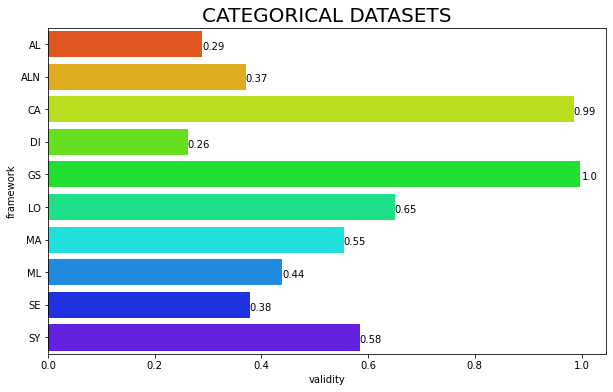

In [64]:
ax = sns.barplot(x = "validity", y = "framework", data = validity_analysis_cat_mean, palette=sns.color_palette("gist_rainbow", 11))
show_values_on_bars(ax, validity_analysis_cat_mean['validity'].tolist())
ax.set_title('CATEGORICAL DATASETS', fontsize=20)
ax.figure.set_size_inches(10,6)

In [65]:
# Mixed
validity_analysis_mix = df_all_results[df_all_results['dataset'].isin(mix_ds)][['framework', 'validity']].copy()
validity_analysis_mix['validity'] = validity_analysis_mix['validity'].fillna(False)

In [66]:
# Calculate mean
validity_analysis_mix_mean = validity_analysis_mix.groupby('framework').mean()
validity_analysis_mix_mean = validity_analysis_mix_mean.reset_index()
validity_analysis_mix_mean['framework'] = validity_analysis_mix_mean['framework'].map(short_frameworks)

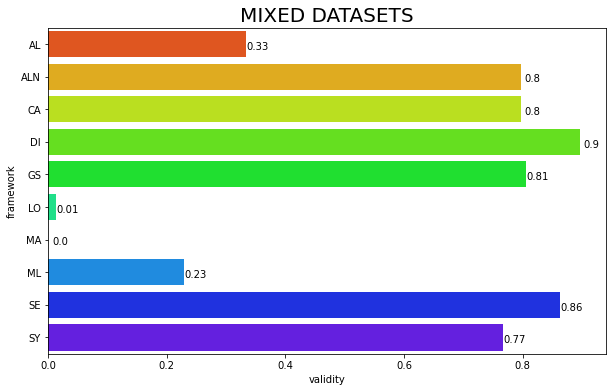

In [67]:
ax = sns.barplot(x = "validity", y = "framework", data = validity_analysis_mix_mean, palette=sns.color_palette("gist_rainbow", 11))
show_values_on_bars(ax, validity_analysis_mix_mean['validity'].tolist())
ax.set_title('MIXED DATASETS', fontsize=20)
ax.figure.set_size_inches(10,6)

In [68]:
# For each dataset and analysis

In [69]:
validity_ds_num_analysis = {}
for ds in dsNames:
    if ds not in validity_ds_num_analysis.keys():
        validity_ds_num_analysis[ds] = {}
    for n in ['0', '1']:
        validity_analysis_ds = df_all_results[(df_all_results['dataset']==ds)&(df_all_results['n']==n)][['framework', 'validity']].copy()
        validity_analysis_ds['validity'] = validity_analysis_ds['validity'].fillna(False)
        
        # Calculate mean
        validity_analysis_ds_mean = validity_analysis_ds.groupby('framework').mean()
        validity_analysis_ds_mean = validity_analysis_ds_mean.reset_index()
        validity_analysis_ds_mean['framework'] = validity_analysis_ds_mean['framework'].map(short_frameworks)
        
        validity_ds_num_analysis[ds][n] = validity_analysis_ds_mean

In [70]:
# Calculate raw metrics for realistic scores

In [106]:
def generate_raw_realisitc_chart(ds_type):
    
    if ds_type == 'all':
        selected_ds = cat_ds+num_ds+mix_ds
        chart_title = 'ALL DATASETS'
    if ds_type == 'num':
        selected_ds = num_ds
        chart_title = 'NUMERICAL DATASETS'
    if ds_type == 'cat':
        selected_ds = cat_ds
        chart_title = 'CATEGORICAL DATASETS'
    if ds_type == 'mix':
        selected_ds = mix_ds
        chart_title = 'MIXED DATASETS'
    
    # Total
    realistic_analysis = df_all_results[df_all_results['dataset'].isin(selected_ds)][['framework', 'RUC', 'RMC', 'validity']].copy()
    mask_valid = realistic_analysis['validity']==True
    realistic_analysis.loc[mask_valid, 'RMC'] = 1
    realistic_analysis['RUC'] = realistic_analysis['RUC'].fillna(0)
    realistic_analysis['RMC'] = realistic_analysis['RMC'].fillna(0)
    realistic_analysis['realistic'] = (realistic_analysis['RUC'] == 1)&(realistic_analysis['RMC'] == 1)
    realistic_analysis = realistic_analysis.drop(columns=['RUC', 'RMC', 'validity'])
    
    # Calculate mean
    realistic_analysis_mean = realistic_analysis.groupby('framework').mean()
    realistic_analysis_mean = realistic_analysis_mean.reset_index()
    realistic_analysis_mean['framework'] = realistic_analysis_mean['framework'].map(short_frameworks)
    
    realistic_analysis_mean.columns = ['framework', 'coverage']
    
    ax = sns.barplot(x = "coverage", y = "framework", data = realistic_analysis_mean, palette=sns.color_palette("gist_rainbow", 11))
    ax.set_xlim(0,1)
    show_values_on_bars(ax, realistic_analysis_mean['coverage'].tolist())
    ax.set_title(chart_title, fontsize=20)
    ax.figure.set_size_inches(10,6)

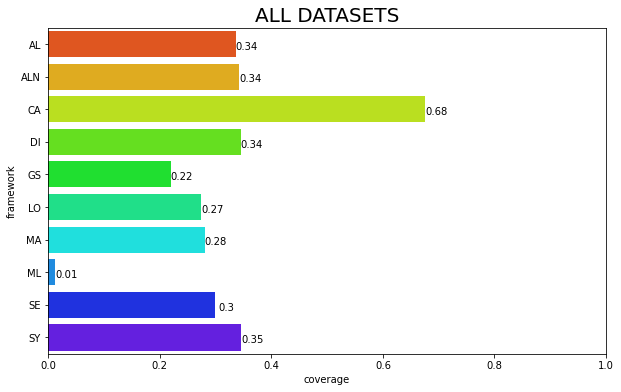

In [107]:
generate_raw_realisitc_chart('all')

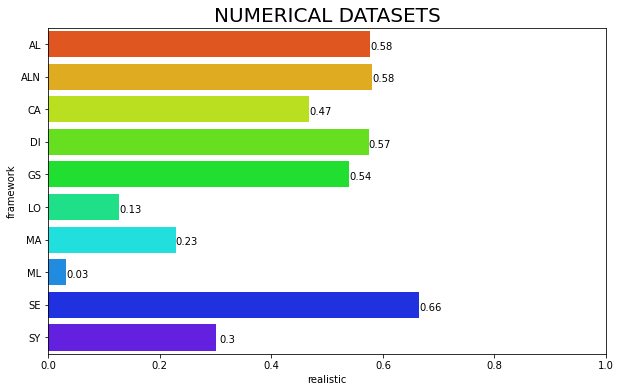

In [86]:
generate_raw_realisitc_chart('num')

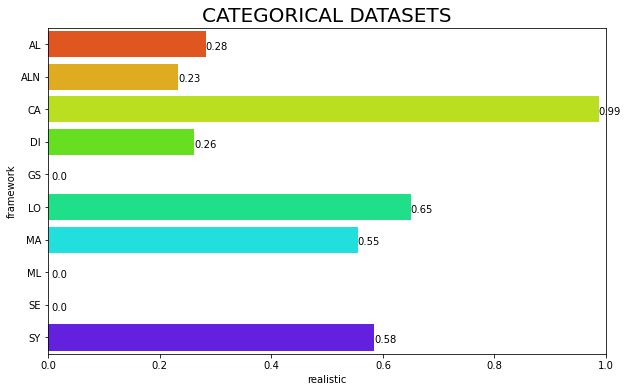

In [87]:
generate_raw_realisitc_chart('cat')

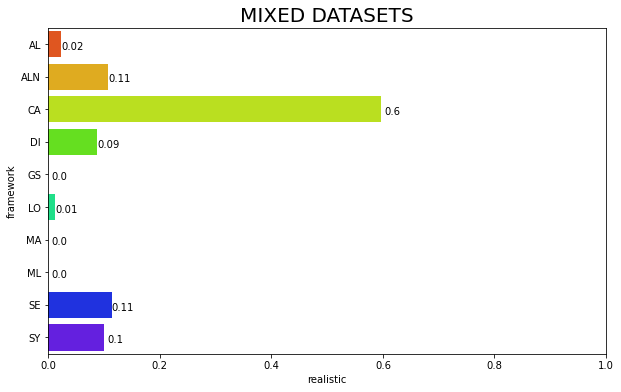

In [88]:
generate_raw_realisitc_chart('mix')

In [89]:
# Calculate, for each framework and dataset, calculate validity found for majority and minority

In [90]:
ds_ratio_analysis = []
for ds in dsNames:
        
    r0_ratio = ratio_df[ratio_df['dataset']==ds]['r0'].tolist()[0]
    
    inbalance_level = ratio_df[ratio_df['dataset']==ds]['ratio_class'].tolist()[0]
    
    majority = '0' if r0_ratio > 0.5 else '1'
    
    minority = '1' if r0_ratio > 0.5 else '0'
    
    ds_row_analysis = validity_ds_num_analysis[ds][majority].copy()
    
    ds_row_analysis = ds_row_analysis.rename(columns={'validity': 'majority'})
    
    ds_row_analysis['dataset'] = ds
        
    ds_row_analysis['minority'] = validity_ds_num_analysis[ds][minority]['validity']
    
    ds_row_analysis['ratio_class'] = inbalance_level
    
    ds_ratio_analysis.append(ds_row_analysis)

ratio_analysis = pd.concat(ds_ratio_analysis)
ratio_analysis['difference'] = ratio_analysis['minority']-ratio_analysis['majority']
ratio_analysis = ratio_analysis[['dataset', 'framework', 'majority', 'minority', 'difference', 'ratio_class']]

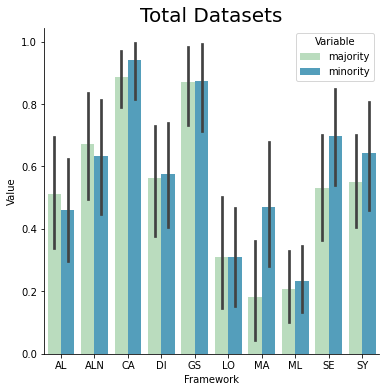

In [91]:
# Total mean validity
fig, ax1 = plt.subplots(figsize=(6, 6))
tidy = ratio_analysis[['framework', 'majority', 'minority']].melt(id_vars='framework').rename(columns=str.title)
fig_parameters = sns.barplot(x='Framework', y='Value', hue='Variable', data=tidy, ax=ax1, palette=sns.color_palette("GnBu", 2))
fig_parameters.set_title('Total Datasets', fontsize=20)
sns.despine(fig)

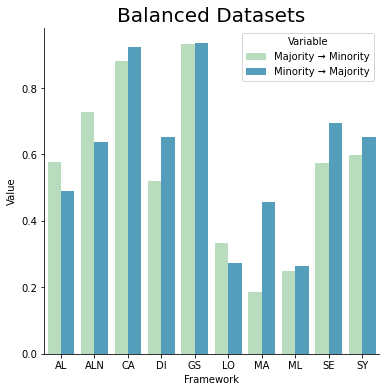

In [92]:
# Mean validity
r_a_b = ratio_analysis[(ratio_analysis['ratio_class'].isin(['b', 'u']))]
mean_r_a_b = r_a_b.groupby('framework').mean()[['majority','minority']]
mean_r_a_b = mean_r_a_b.rename(columns = {'majority': 'Majority ➞ Minority', 'minority': 'Minority ➞ Majority'})
mean_r_a_b = mean_r_a_b.reset_index()
# mean_r_a_b.plot.bar()
fig, ax1 = plt.subplots(figsize=(6, 6))
tidy = mean_r_a_b.melt(id_vars='framework').rename(columns=str.title)
fig_parameters = sns.barplot(x='Framework', y='Value', hue='Variable', data=tidy, ax=ax1, palette=sns.color_palette("GnBu", 2))
fig_parameters.set_title('Balanced Datasets', fontsize=20)
sns.despine(fig)

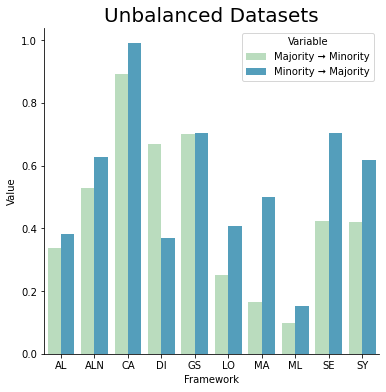

In [80]:
# Mean validity
r_a_b = ratio_analysis[(ratio_analysis['ratio_class'].isin(['hu']))]
mean_r_a_b = r_a_b.groupby('framework').mean()[['majority','minority']]
mean_r_a_b = mean_r_a_b.rename(columns = {'majority': 'Majority ➞ Minority', 'minority': 'Minority ➞ Majority'})
mean_r_a_b = mean_r_a_b.reset_index()
# mean_r_a_b.plot.bar()
fig, ax1 = plt.subplots(figsize=(6, 6))
tidy = mean_r_a_b.melt(id_vars='framework').rename(columns=str.title)
fig_parameters = sns.barplot(x='Framework', y='Value', hue='Variable', data=tidy, ax=ax1, palette=sns.color_palette("GnBu", 2))
fig_parameters.set_title('Unbalanced Datasets', fontsize=20)
sns.despine(fig)

In [81]:
## Decision Tree To Find Best Approach

In [ ]:
# Get dataset and model characteristics and labels are the best performing methods

In [ ]:
df_all_results

In [ ]:
validity_raw_analysis = df_all_results[['framework', 'n', 'validity', 'dataset']].copy()

In [ ]:
validity_raw_analysis['validity'] = validity_raw_analysis['validity'].fillna(False).map(int)

In [ ]:
validity_raw_analysis_0 = validity_raw_analysis[validity_raw_analysis['n']=='0'].groupby(['dataset', 'framework']).mean()['validity'].to_frame().reset_index()

In [ ]:
validity_raw_analysis_1 =  validity_raw_analysis[validity_raw_analysis['n']=='1'].groupby(['dataset', 'framework']).mean()['validity'].to_frame().reset_index()

In [ ]:
ratio_df[ratio_df['ratio_class']=='hu']['dataset'].unique()

In [ ]:
def better_majority_or_minority(row):
    ds_r0 = ratio_df[ratio_df['dataset']==row['dataset']]['r0'].tolist()[0]
    
    if ds_r0 > 0.5:
        # 0 is majority
        if row['v1'] > row['v0']:
            # Going to majority is better
            return 'MAJORITY'
        if row['v1'] < row['v0']:
            # Going to minority is better
            return 'minority'
        else:
            # Same, no changes
            return 'draw'
    else:
        # 1 is majority
        if row['v1'] > row['v0']:
            # Going to minority is better
            return 'minority'
        if row['v1'] < row['v0']:
            # Going to majority is better
            return 'MAJORITY'
        else:
            # Same, no changes
            return 'draw'

In [ ]:
selected_fw = 'SEDC'

In [ ]:
sfvr0 = validity_raw_analysis_0[(validity_raw_analysis_0['framework']==selected_fw)&(validity_raw_analysis_0['dataset'].isin(mix_ds))]
sfvr1 = validity_raw_analysis_1[(validity_raw_analysis_1['framework']==selected_fw)&(validity_raw_analysis_1['dataset'].isin(mix_ds))]

In [ ]:
sfvr0 = sfvr0.rename(columns={'validity': 'v0'})
sfvr0['v1'] = sfvr1['validity']
sfvr0['preference'] = sfvr0.apply(lambda x:better_majority_or_minority(x), axis=1)

In [ ]:
sfvr0

In [ ]:
ratio_df[ratio_df['dataset'].isin(cat_ds)]

In [ ]:
## Numerical Analysis

In [ ]:
## Grouped ranking

In [ ]:
df_all_results_test = df_all_results.copy()

In [ ]:
df_all_results_test

In [ ]:
df_all_results_realistic = df_all_results.copy()

mask_unrealistic = df_all_results_realistic[['RUC', 'RMC']].apply(lambda x: 0 in [x['RUC'], x['RMC']], axis=1)
    
df_all_results_realistic.loc[mask_unrealistic, 'validity'] = False
df_all_results_realistic.loc[mask_unrealistic, 'validityFound'] = False
df_all_results_realistic.loc[mask_unrealistic, 'sparsity']= np.nan
df_all_results_realistic.loc[mask_unrealistic, 'L2'] = np.nan
df_all_results_realistic.loc[mask_unrealistic, 'RUC'] = np.nan
df_all_results_realistic.loc[mask_unrealistic, 'RMC'] = np.nan
df_all_results_realistic.loc[mask_unrealistic, 'MAD'] = np.nan
df_all_results_realistic.loc[mask_unrealistic, 'MD'] = np.nan

In [ ]:
test = df_all_results_realistic[df_all_results_realistic['dataset'].isin(num_ds)]

In [ ]:
test[test['validity']==True]['framework'].value_counts()

In [ ]:
# df_all_results_test.apply(lambda x: )

In [ ]:
def generate_rank_analysis(ds_selection, n_list=['0', '1']):
    
    # Validity, RUC and RMC can not have NaN as value, as they are binary states ! NaN must be converted to 0
    
    rank_rows = []
    for ds in ds_selection:
        for n in n_list:
            df_s = df_all_results[(df_all_results['dataset']==ds)&(df_all_results['n']==n)]
            for ds_idx in list(df_s['index'].unique()):
                df_s_idx = df_s[df_s['index']==ds_idx]

                rank_max_row = df_s_idx.set_index('framework').drop(columns=['index', 'n', 'validityFound', 'dataset', 'L2', 'MAD', 'MD']).T.rank(na_option='bottom', axis=1, ascending=False)
                rank_min_row = df_s_idx.set_index('framework').drop(columns=['index', 'n', 'validityFound', 'dataset', 'validity', 'sparsity', 'RUC', 'RMC']).T.rank(na_option='bottom', axis=1)

                rank_row = pd.concat([rank_max_row, rank_min_row])
                rank_rows.append(rank_row)
    best_dfs = (sum(rank_rows)/len(rank_rows))
    best_dfs['N'] = len(rank_rows)
    
    return best_dfs

In [ ]:
def generate_rank_analysis_realistic(ds_selection, n_list=['0', '1']):
    
    # Validity, RUC and RMC can not have NaN as value, as they are binary states ! NaN must be converted to 0
    
    rank_rows = []
    
    df_all_results_realistic = df_all_results.copy()
    mask_unrealistic = df_all_results_realistic[['RUC', 'RMC']].apply(lambda x: 0 in [x['RUC'], x['RMC']], axis=1)
    
    df_all_results_realistic.loc[mask_unrealistic, 'validity'] = False
    df_all_results_realistic.loc[mask_unrealistic, 'validityFound'] = False
    df_all_results_realistic.loc[mask_unrealistic, 'sparsity']= np.nan
    df_all_results_realistic.loc[mask_unrealistic, 'L2'] = np.nan
    df_all_results_realistic.loc[mask_unrealistic, 'RUC'] = np.nan
    df_all_results_realistic.loc[mask_unrealistic, 'RMC'] = np.nan
    df_all_results_realistic.loc[mask_unrealistic, 'MAD'] = np.nan
    df_all_results_realistic.loc[mask_unrealistic, 'MD'] = np.nan
    
    for ds in ds_selection:
        for n in n_list:
            df_s = df_all_results_realistic[(df_all_results_realistic['dataset']==ds)&(df_all_results_realistic['n']==n)]
            for ds_idx in list(df_s['index'].unique()):
                df_s_idx = df_s[df_s['index']==ds_idx]

                rank_max_row = df_s_idx.set_index('framework').drop(columns=['index', 'n', 'validityFound', 'dataset', 'L2', 'MAD', 'MD']).T.rank(na_option='bottom', axis=1, ascending=False)
                rank_min_row = df_s_idx.set_index('framework').drop(columns=['index', 'n', 'validityFound', 'dataset', 'validity', 'sparsity', 'RUC', 'RMC']).T.rank(na_option='bottom', axis=1)

                rank_row = pd.concat([rank_max_row, rank_min_row])
                rank_rows.append(rank_row)
    best_dfs = (sum(rank_rows)/len(rank_rows))
    best_dfs['N'] = len(rank_rows)
    
    return best_dfs

In [ ]:
def highlight_group_best(s):
    '''
    highlight the statistically significant with gray.
    '''
    
    k = len(s.index)-1
    N = s['N']
    s_clean = s.drop('N')
    
    spx2f = sum([(R-(k+1)/2)**2 for R in s_clean.values])

    x2f = 12*N/(k*(k+1))*spx2f

    ff = (N-1)*x2f/(N*(k-1)-x2f)

    # 95% of confidence
    critical_f_value = sp.stats.f.ppf(q=1-.05, dfn=k-1, dfd=N-1)
    
    reject_h0 = True if ff >= critical_f_value else False
    
    if reject_h0:
    
        cd = cvnt005[k]*(k*(k+1)/(6*N))**0.5

        # Get best frameworks
        bests_fws = list(s_clean[s_clean<=(s_clean.min()+cd)].index)

        return ['background-color: gray' if v in bests_fws else '' for v in list(s.index)]
    else:
        return ['' for v in list(s.index)]


In [ ]:
def calc_critical_dif(scores, N):
    k = len(scores)
    
    spx2f = sum([(R-(k+1)/2)**2 for R in scores])
    x2f = 12*N/(k*(k+1))*spx2f
    ff = (N-1)*x2f/(N*(k-1)-x2f)
    
    # 95% of confidence
    critical_f_value = sp.stats.f.ppf(q=1-.05, dfn=k-1, dfd=N-1)
    
    reject_h0 = True if ff >= critical_f_value else False
    
    if reject_h0:
    
        cd = cvnt005[k]*(k*(k+1)/(6*N))**0.5

        return cd
    
    return -1
    

In [ ]:
# # Calculate Raw Time
# time_data = []
# for pr in processed_results:
#     if 'TIME' in pr:
#         t_df = pd.read_csv(f'./results/processed/{pr}')
#         t_df['3'] = t_df['3'].fillna(1800)
        
#         dsn = t_df['2'].unique()[0]
#         fw = pr.split('_')[-1].split('.')[0]
        
#         meant = t_df['3'].mean()
#         mean0 = t_df[t_df['1']==0]['3'].mean()
#         mean1 = t_df[t_df['1']==1]['3'].mean()
        
#         stdt = t_df['3'].std()
#         std0 = t_df[t_df['1']==0]['3'].std()
#         std1 = t_df[t_df['1']==1]['3'].std()
        
#         time_data.append([dsn, fw, meant, stdt, mean0, std0, mean1, std1 ])
# df_time = pd.DataFrame(time_data, columns=['dataset', 'framework', 'total', 'std', 'n0', 'std0', 'n1', 'std1'])

In [ ]:
all_df_time = []
for fn in os.listdir('./benchmark/log_bench/results/'):
    
    dsn = list(VAR_TYPES.keys())[int(fn.split('_')[4])]
    n = int(fn.split('_')[5][0])
    fw = fn.split('_')[3].split('.')[0]
    
    df_all = pd.read_csv('./benchmark/log_bench/results/'+fn, ' ', header=None, error_bad_lines=False)
    df_all = df_all[[2,4]]
    df_all.columns = ['time', 'error']
    df_all['error'].map({'SUCCESS': 0, 'ERROR': 1})
    df_all['dataset'] = dsn
    df_all['framework'] = fw
    df_all['n'] = n
    
    all_df_time.append(df_all)

df_time_full = pd.concat(all_df_time)
df_time_full = df_time_full[['dataset', 'framework', 'n', 'error', 'time']]

In [ ]:
df_total = df_time_full.groupby(['framework', 'dataset'])['time']
df_total_time = df_total.sum()
df_mean_time = df_total.mean()
df_std_time = df_total.std()

df_total_0 = df_time_full[df_time_full['n']==0].groupby(['framework', 'dataset'])['time']
df_total_time_0 = df_total_0.sum()
df_mean_time_0 = df_total_0.mean()
df_std_time_0 = df_total_0.std()

df_total_1 = df_time_full[df_time_full['n']==1].groupby(['framework', 'dataset'])['time']
df_total_time_1 = df_total_1.sum()
df_mean_time_1 = df_total_1.mean()
df_std_time_1 = df_total_1.std()

In [ ]:
df_time = pd.concat([df_total_time, df_mean_time, df_std_time, 
                     df_total_time_0, df_mean_time_0, df_std_time_0,
                     df_total_time_1, df_mean_time_1, df_std_time_1], axis=1)

df_time = df_time.reset_index()
df_time.columns = ['framework', 'dataset', 
                   'total', 'mean', 'std',
                   'total_0', 'mean_0', 'std_0',
                   'total_1', 'mean_1', 'std_1']

In [ ]:
# Replication Analysis
data_robustness = []
for fw in framework_names:
    for dsname in dsNames:
        for n in [0, 1]:
            
            try:
                # Result dataset, give some room to mathematical approximations
                res_ds = pd.read_csv(f'./results/processed/{n}_{dsname}_{fw}.csv').apply(lambda x: round(x, 5))
            except:
                res_ds = ''
            
            if res_ds is not '':
                # Replication dataset, give some room to mathematical approximations
                rep_ds = pd.read_csv(f'./replication/processed/{n}_{dsname}_{fw}.csv').apply(lambda x: round(x, 5))
                
                total_dif = ((res_ds.fillna('n')!=rep_ds.fillna('n')).sum(axis=1)>0).sum()

                # Total number of rows that generated results
                total_n_rows = len(set(list(res_ds.dropna().index)+list(rep_ds.dropna().index)))
                
                
                if total_n_rows > 0:
                    robustness = 1 - float(total_dif)/float(total_n_rows)
                else:
                    robustness = np.nan
                
                data_robustness.append([dsname, fw, n, robustness])
            else:
                data_robustness.append([dsname, fw, n, np.nan])

In [ ]:
df_rob = pd.DataFrame(data_robustness)
df_rob.columns = ['dataset', 'framework', 'n', 'robustness']

In [ ]:
df_rob

In [ ]:
#############################################
# Robustness Analysis

In [ ]:
# Categorical
df_rob_cat = pd.DataFrame(df_rob[df_rob['dataset'].isin(cat_ds)].copy().groupby('framework')['robustness'].mean())
df_rob_cat['ds_type'] = 'categorical'

In [ ]:
# Numerical
df_rob_num = pd.DataFrame(df_rob[df_rob['dataset'].isin(num_ds)].copy().groupby('framework')['robustness'].mean())
df_rob_num['ds_type'] = 'numerical'

In [ ]:
# Mixed
df_rob_mix = pd.DataFrame(df_rob[df_rob['dataset'].isin(mix_ds)].copy().groupby('framework')['robustness'].mean())
df_rob_mix['ds_type'] = 'mixed'

In [ ]:
data_robustness = pd.concat([df_rob_cat, df_rob_num, df_rob_mix]).reset_index()
data_robustness['framework'] = data_robustness['framework'].map(short_frameworks)
data_robustness = data_robustness.pivot('ds_type', 'framework', 'robustness')

In [ ]:
data_robustness

In [ ]:
f, ax = plt.subplots(figsize=(15, 3))
ax.set(xlabel='Framework', ylabel='Stability')
sns.barplot(data=data_robustness, palette=sns.color_palette("gist_rainbow", 11))

In [ ]:
#############################################

In [ ]:
#############################################
# Time chart

In [ ]:
# All Datasets

In [ ]:
ds_total_columns = ds_characteristics[['Dataset', 'Columns Total']].copy()
ds_total_columns.columns = ['dataset', 'total_cols']

In [ ]:
df_time_graph = df_time.copy().merge(ds_total_columns, how='right', on='dataset')
df_time_graph_data = df_time_graph[['total_cols', 'framework', 'total']] 

In [ ]:
df_time_graph_data = df_time_graph_data.groupby(['framework', 'total_cols']).mean().reset_index().pivot('total_cols', 'framework', 'total')

In [ ]:
df_time_graph_data = df_time_graph_data

In [ ]:
sns.lineplot(data=df_time_graph_data)

In [ ]:
# Categorical Datasets - Numer of columns

In [ ]:
ds_cat_columns = ds_characteristics[ds_characteristics['Dataset'].isin(cat_ds)][['Dataset', 'Columns Total']].copy()
ds_cat_columns.columns = ['dataset', 'total_cols']

In [ ]:
df_time_graph_cat = df_time.copy().merge(ds_cat_columns, how='right', on='dataset')
df_time_graph_cat['framework'] = df_time_graph_cat['framework'].map(short_frameworks)
df_time_graph_cat_data = df_time_graph_cat[['total_cols', 'framework', 'mean']]

In [ ]:
df_time_graph_cat_data = df_time_graph_cat_data.groupby(['framework', 'total_cols']).mean().reset_index().pivot('total_cols', 'framework', 'mean')

In [ ]:
df_time_graph_cat_data.index.name = "Number of columns"
sns.heatmap(df_time_graph_cat_data, cmap="YlGnBu")

In [ ]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xlabel='Number of columns', ylabel='Time (s)')
sns.lineplot(data=df_time_graph_cat_data, linewidth = 3)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
# Categorical Datasets - Numer of Rows

In [ ]:
ds_cat_columns = ds_characteristics[ds_characteristics['Dataset'].isin(cat_ds)][['Dataset', 'Rows (train)']].copy()
ds_cat_columns.columns = ['dataset', 'Rows (train)']

In [ ]:
df_time_graph_cat = df_time.copy().merge(ds_cat_columns, how='right', on='dataset')
df_time_graph_cat['framework'] = df_time_graph_cat['framework'].map(short_frameworks)
df_time_graph_cat_data = df_time_graph_cat[['Rows (train)', 'framework', 'mean']]

In [ ]:
df_time_graph_cat_data = df_time_graph_cat_data.groupby(['framework', 'Rows (train)']).mean().reset_index().pivot('Rows (train)', 'framework', 'mean')

In [ ]:
df_time_graph_cat_data.index.name = "Number of columns"
sns.heatmap(df_time_graph_cat_data, cmap="YlGnBu")

In [ ]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xlabel='Number of rows', ylabel='Time (s)')
sns.lineplot(data=df_time_graph_cat_data, linewidth = 3)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
# Numerical Datasets - Columns

In [ ]:
ds_num_columns = ds_characteristics[ds_characteristics['Dataset'].isin(num_ds)][['Dataset', 'Columns Total']].copy()
ds_num_columns.columns = ['dataset', 'total_cols']

In [ ]:
df_time_graph_num = df_time.copy().merge(ds_num_columns, how='right', on='dataset')
df_time_graph_num['framework'] = df_time_graph_num['framework'].map(short_frameworks)
df_time_graph_num_data = df_time_graph_num[['total_cols', 'framework', 'mean']]

In [ ]:
df_time_graph_num_data = df_time_graph_num_data.groupby(['framework', 'total_cols']).mean().reset_index().pivot('total_cols', 'framework', 'mean')

In [ ]:
df_time_graph_num_data.index.name = "Number of columns"
sns.heatmap(df_time_graph_num_data, cmap="YlGnBu")

In [ ]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xlabel='Number of columns', ylabel='Time (s)')
sns.lineplot(data=df_time_graph_num_data, linewidth = 3)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
# Numerical Datasets - Rows

In [ ]:
ds_num_columns = ds_characteristics[ds_characteristics['Dataset'].isin(num_ds)][['Dataset', 'Rows (train)']].copy()
ds_num_columns.columns = ['dataset', 'Rows (train)']

In [ ]:
df_time_graph_num = df_time.copy().merge(ds_num_columns, how='right', on='dataset')
df_time_graph_num['framework'] = df_time_graph_num['framework'].map(short_frameworks)
df_time_graph_num_data = df_time_graph_num[['Rows (train)', 'framework', 'mean']]

In [ ]:
df_time_graph_num_data = df_time_graph_num_data.groupby(['framework', 'Rows (train)']).mean().reset_index().pivot('Rows (train)', 'framework', 'mean')

In [ ]:
df_time_graph_num_data.index.name = "Number of columns"
sns.heatmap(df_time_graph_num_data, cmap="YlGnBu")

In [ ]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xlabel='Number of rows', ylabel='Time (s)')
sns.lineplot(data=df_time_graph_num_data, linewidth = 3)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
# Mixed Datasets - Columns

In [ ]:
ds_mix_columns = ds_characteristics[ds_characteristics['Dataset'].isin(mix_ds)][['Dataset', 'Columns Total']].copy()
ds_mix_columns.columns = ['dataset', 'total_cols']

In [ ]:
df_time_graph_mix = df_time.copy().merge(ds_mix_columns, how='right', on='dataset')
df_time_graph_mix['framework'] = df_time_graph_mix['framework'].map(short_frameworks)
df_time_graph_mix_data = df_time_graph_mix[['total_cols', 'framework', 'mean']]

In [ ]:
df_time_graph_mix_data = df_time_graph_mix_data.groupby(['framework', 'total_cols']).mean().reset_index().pivot('total_cols', 'framework', 'mean')

In [ ]:
df_time_graph_mix_data.index.name = 'Number of columns'
sns.heatmap(df_time_graph_mix_data.rename(columns={'total_cols': "Number of columns"}), cmap="YlGnBu")

In [ ]:
#############################################

In [ ]:
#############################################
# Make list of winners

In [ ]:

def generate_analysis(df, score):
    analyzed = df.loc[score]
    analyzed_scores = analyzed.drop('N')
    N = analyzed['N']
    
    cd = calc_critical_dif(analyzed_scores, N)
    threshold_first = cd + analyzed_scores.min()
    
    output = pd.DataFrame(analyzed_scores)
    output['is_best_'+score] = output[score] <= threshold_first
    
    output = output.sort_values(score)
    
    return output

In [ ]:
# Total
total_ds_analysis = generate_rank_analysis(dsNames)

In [ ]:
# Total time
time_total = df_time[['framework', 'total']].groupby('framework').mean()

# Total robustness
rob_total = df_rob[['framework', 'robustness']].groupby('framework').mean()

In [ ]:
total_validity = generate_analysis(total_ds_analysis, 'validity')
total_sparsity = generate_analysis(total_ds_analysis, 'sparsity')
total_ruc = generate_analysis(total_ds_analysis, 'RUC')
total_rmc = generate_analysis(total_ds_analysis, 'RMC')
total_l2 = generate_analysis(total_ds_analysis, 'L2')
total_mad = generate_analysis(total_ds_analysis, 'MAD')
total_md = generate_analysis(total_ds_analysis, 'MD')

In [ ]:
pd.concat([total_validity, total_sparsity, total_ruc, total_rmc, total_l2, total_mad, total_md, time_total, rob_total], axis=1).to_csv('./rankings/total.csv')

In [ ]:
# Categorical
categorical_ds_analysis = generate_rank_analysis(cat_ds)

In [ ]:
# Cat time
time_cat = df_time[df_time['dataset'].isin(cat_ds)][['framework', 'total']].groupby('framework').mean()

# Cat robustness
rob_cat = df_rob[df_rob['dataset'].isin(cat_ds)][['framework', 'robustness']].groupby('framework').mean()

In [ ]:
cat_validity = generate_analysis(categorical_ds_analysis, 'validity')
cat_sparsity = generate_analysis(categorical_ds_analysis, 'sparsity')
cat_ruc = generate_analysis(categorical_ds_analysis, 'RUC')
cat_rmc = generate_analysis(categorical_ds_analysis, 'RMC')
cat_l2 = generate_analysis(categorical_ds_analysis, 'L2')
cat_mad = generate_analysis(categorical_ds_analysis, 'MAD')
cat_md = generate_analysis(categorical_ds_analysis, 'MD')

In [ ]:
pd.concat([cat_validity, cat_sparsity, cat_ruc, cat_rmc, cat_l2, cat_mad, cat_md, time_cat, rob_cat], axis=1).to_csv('./rankings/categorical.csv')

In [ ]:
# Numerical
numerical_ds_analysis = generate_rank_analysis(num_ds)

In [ ]:
# Num time
time_num = df_time[df_time['dataset'].isin(num_ds)][['framework', 'total']].groupby('framework').mean()

# Num robustness
rob_num = df_rob[df_rob['dataset'].isin(num_ds)][['framework', 'robustness']].groupby('framework').mean()

In [ ]:
num_validity = generate_analysis(numerical_ds_analysis, 'validity')
num_sparsity = generate_analysis(numerical_ds_analysis, 'sparsity')
num_ruc = generate_analysis(numerical_ds_analysis, 'RUC')
num_rmc = generate_analysis(numerical_ds_analysis, 'RMC')
num_l2 = generate_analysis(numerical_ds_analysis, 'L2')
num_mad = generate_analysis(numerical_ds_analysis, 'MAD')
num_md = generate_analysis(numerical_ds_analysis, 'MD')

In [ ]:
pd.concat([num_validity, num_sparsity, num_ruc, num_rmc, num_l2, num_mad, num_md, time_num, rob_num], axis=1).to_csv('./rankings/numerical.csv')

In [ ]:
# Mixed
mixed_ds_analysis = generate_rank_analysis(mix_ds)

In [ ]:
# Num time
time_mix = df_time[df_time['dataset'].isin(mix_ds)][['framework', 'total']].groupby('framework').mean()

# Num robustness
rob_mix = df_rob[df_rob['dataset'].isin(mix_ds)][['framework', 'robustness']].groupby('framework').mean()

In [ ]:
mix_validity = generate_analysis(mixed_ds_analysis, 'validity')
mix_sparsity = generate_analysis(mixed_ds_analysis, 'sparsity')
mix_ruc = generate_analysis(mixed_ds_analysis, 'RUC')
mix_rmc = generate_analysis(mixed_ds_analysis, 'RMC')
mix_l2 = generate_analysis(mixed_ds_analysis, 'L2')
mix_mad = generate_analysis(mixed_ds_analysis, 'MAD')
mix_md = generate_analysis(mixed_ds_analysis, 'MD')

In [ ]:
mix_validity

In [ ]:
pd.concat([mix_validity, mix_sparsity, mix_ruc, mix_rmc, mix_l2, mix_mad, mix_md, time_mix, rob_mix], axis=1).to_csv('./rankings/mixed.csv')

In [ ]:
#############################################

In [ ]:
# Total
total_ds_analysis = generate_rank_analysis(dsNames)

In [ ]:
import plotly.graph_objects as go

scores = ['validity', 'sparsity', 'L2', 'MAD', 'MD']

data = total_ds_analysis.loc[scores, framework_names]

fig = go.Figure()

for fw in framework_names:
    
    fig.add_trace(go.Scatterpolar(
        r=data[fw].tolist(),
        theta = scores,
#         fill='toself',
        name=short_frameworks[fw]
    ))
    
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[data.max().max(), data.min().min()]
    )),
#   showlegend=False
)

fig.show()

In [ ]:
total_ds_analysis.rename(columns={'GROWINGSPHERES3': 'GROWINGSPHERES'}).style.apply(highlight_group_best, axis=1)

In [ ]:
total_ds_analysis.rename(columns={'GROWINGSPHERES3': 'GROWINGSPHERES'}).style.apply(highlight_group_best, axis=1).to_excel('total_ds_analysis.xlsx')

In [ ]:
# Categorical
cat_ds_analysis = generate_rank_analysis(cat_ds)
cat_ds_analysis.rename(columns={'GROWINGSPHERES3': 'GROWINGSPHERES'}).style.apply(highlight_group_best, axis=1)

In [ ]:
cat_ds_analysis.style.apply(highlight_group_best, axis=1).to_excel('cat_ds_analysis.xlsx')

In [ ]:
# Numerical
num_ds_analysis = generate_rank_analysis(num_ds)
num_ds_analysis.rename(columns={'GROWINGSPHERES3': 'GROWINGSPHERES'}).style.apply(highlight_group_best, axis=1)

In [ ]:
num_ds_analysis.style.apply(highlight_group_best, axis=1).to_excel('num_ds_analysis.xlsx')

In [ ]:
# Mixed
mix_ds_analysis = generate_rank_analysis(mix_ds)
mix_ds_analysis.rename(columns={'GROWINGSPHERES3': 'GROWINGSPHERES'}).style.apply(highlight_group_best, axis=1)

In [ ]:
mix_ds_analysis.style.apply(highlight_group_best, axis=1).to_excel('mix_ds_analysis.xlsx')

In [ ]:
# Make same analysis before, but considering only valid

In [ ]:
# Total
total_ds_analysis_realistic = generate_rank_analysis_realistic(dsNames)
total_ds_analysis_realistic.rename(columns={'GROWINGSPHERES3': 'GROWINGSPHERES'}).style.apply(highlight_group_best, axis=1)

In [ ]:
scores = ['validity', 'sparsity', 'L2', 'MAD', 'MD']

data = total_ds_analysis_realistic.loc[scores, framework_names]

fig = go.Figure()

for fw in framework_names:
    
    fig.add_trace(go.Scatterpolar(
        r=data[fw].tolist(),
        theta = scores,
#         fill='toself',
        name=short_frameworks[fw]
    ))
    
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[data.max().max(), data.min().min()]
    )),
#   showlegend=False
)

fig.show()

In [ ]:
total_ds_analysis_realistic.rename(columns={'GROWINGSPHERES3': 'GROWINGSPHERES'}).style.apply(highlight_group_best, axis=1).to_excel('total_ds_analysis_realistic.xlsx')

In [ ]:
# Categorical
cat_ds_analysis_realistic = generate_rank_analysis_realistic(cat_ds)
cat_ds_analysis_realistic.rename(columns={'GROWINGSPHERES3': 'GROWINGSPHERES'}).style.apply(highlight_group_best, axis=1)

In [ ]:
cat_ds_analysis_realistic.rename(columns={'GROWINGSPHERES3': 'GROWINGSPHERES'}).style.apply(highlight_group_best, axis=1).to_excel('cat_ds_analysis_realistic.xlsx')

In [ ]:
rank_rows = []
    
df_all_results_realistic = df_all_results.copy()
mask_unrealistic = df_all_results_realistic[['RUC', 'RMC']].apply(lambda x: 0 in [x['RUC'], x['RMC']], axis=1)

df_all_results_realistic.loc[mask_unrealistic, 'validity'] = False
df_all_results_realistic.loc[mask_unrealistic, 'validityFound'] = False
df_all_results_realistic.loc[mask_unrealistic, 'sparsity']= np.nan
df_all_results_realistic.loc[mask_unrealistic, 'L2'] = np.nan
df_all_results_realistic.loc[mask_unrealistic, 'RUC'] = np.nan
df_all_results_realistic.loc[mask_unrealistic, 'RMC'] = np.nan
df_all_results_realistic.loc[mask_unrealistic, 'MAD'] = np.nan
df_all_results_realistic.loc[mask_unrealistic, 'MD'] = np.nan

for ds in num_ds:
    for n in ['0', '1']:
        df_s = df_all_results_realistic[(df_all_results_realistic['dataset']==ds)&(df_all_results_realistic['n']==n)]
        for ds_idx in list(df_s['index'].unique()):
            df_s_idx = df_s[df_s['index']==ds_idx]

            rank_max_row = df_s_idx.set_index('framework').drop(columns=['index', 'n', 'validityFound', 'dataset', 'L2', 'MAD', 'MD']).T.rank(na_option='bottom', axis=1, ascending=False)
            rank_min_row = df_s_idx.set_index('framework').drop(columns=['index', 'n', 'validityFound', 'dataset', 'validity', 'sparsity', 'RUC', 'RMC']).T.rank(na_option='bottom', axis=1)

            rank_row = pd.concat([rank_max_row, rank_min_row])
            rank_rows.append(rank_row)
best_dfs = (sum(rank_rows)/len(rank_rows))
best_dfs['N'] = len(rank_rows)

In [ ]:
# Numerical
num_ds_analysis_realistic = generate_rank_analysis_realistic(num_ds)
num_ds_analysis_realistic.rename(columns={'GROWINGSPHERES3': 'GROWINGSPHERES'}).style.apply(highlight_group_best, axis=1)

In [ ]:
num_ds_analysis_realistic.rename(columns={'GROWINGSPHERES3': 'GROWINGSPHERES'}).style.apply(highlight_group_best, axis=1).to_excel('num_ds_analysis_realistic.xlsx')

In [ ]:
# Mixed
mix_ds_analysis_realistic = generate_rank_analysis_realistic(mix_ds)
mix_ds_analysis_realistic.rename(columns={'GROWINGSPHERES3': 'GROWINGSPHERES'}).style.apply(highlight_group_best, axis=1)

In [ ]:
mix_ds_analysis_realistic.rename(columns={'GROWINGSPHERES3': 'GROWINGSPHERES'}).style.apply(highlight_group_best, axis=1).to_excel('mix_ds_analysis_realistic.xlsx')

In [ ]:
# Make Analysis for each dataset and class

In [ ]:
## Grouped ranking

In [ ]:
pd.DataFrame({'framework':[fw]*n_rows, 'n': [n]*n_rows, 'validity': [False]*n_rows, 
             'validityFound': [False]*n_rows, 'sparsity': [np.nan]*n_rows, 'L2': [np.nan]*n_rows, 
             'RUC': [np.nan]*n_rows, 'RMC': [np.nan]*n_rows, 'MAD': [np.nan]*n_rows, 'MD': [np.nan]*n_rows})

In [ ]:
pd.DataFrame(dict_results['SDD']['0'][0])

In [ ]:
scores_parameters = {
    'validity': 'max',
    'sparsity': 'max',
    'L2': 'min',
    'RUC': 'max',
    'RMC': 'max',
    'MAD': 'min',
    'MD': 'min'
}

In [ ]:
def calculate_rankings(row, d):
    best_values = row.dropna().unique()

    if d == 'max':
        best_values[::-1].sort()
    if d == 'min':
        best_values.sort()

    ranking_row = {}

    counter_score = 1
    for bv in best_values:
        sfw = list(row[row == bv].index)
        score = sum([*range(counter_score, counter_score + len(sfw))])/len(sfw)
        counter_score += len(sfw)
        for fw in sfw:
            ranking_row[fw] = score

    nan_fws = list(set(framework_names) - set(ranking_row.keys()))
    if len(nan_fws) > 0:
        nan_score = sum([*range(counter_score, counter_score + len(nan_fws))]) / len(nan_fws)

        for fw in nan_fws:
            ranking_row[fw] = nan_score

    return ranking_row

In [ ]:
def get_mean_ranking(dsName, n, parameter, d):
    data_results = dict_results[dsName][n]
    total_parameter = []
    names_frameworks = []
    number_of_rows = -1
    for data in data_results:
        names_frameworks.append(data['framework'])
        total_parameter.append(data[parameter])
        if number_of_rows == -1:
            number_of_rows = len(data[parameter])
        else:
            assert len(data[parameter]) == number_of_rows

    df_param = pd.DataFrame(total_parameter).T
    df_param.columns = names_frameworks

    ranking_all_rows = []
    for idx, row in df_param.iterrows():

        ranking_row = calculate_rankings(row, d)

        ranking_all_rows.append(ranking_row)

    return ranking_all_rows

In [ ]:
result_rows_best = []
result_all_rows = []
for dsName in dict_results.keys():
    for n in dict_results[dsName].keys():
        # Just to get the frameworks sorted
        frameworks_sorted = np.sort(framework_names).tolist()
        
        ####################################################
        # Row Specific results
        ####################################################
        cat_feats = VAR_TYPES[dsName]['categorical']
        num_feats = VAR_TYPES[dsName]['numerical']

        df = pd.read_csv(f'./data/{dsName}.csv')
        # Define the majority class as 0 and the other classes as 1, binarization
        most_common_class = df['output'].value_counts().index[0]
        df['output'] = df['output'].apply(lambda x: 0 if x==most_common_class else 1)

        df_fc_idxs = pd.read_csv(f'./experiments_data/{dsName}_CFDATASET_{n}.csv')['Unnamed: 0']

        if len(cat_feats) > 0 and len(num_feats) > 0:
            df_oh = pd.read_csv(f'./data/OH_NORM_{dsName}.csv')
        elif len(cat_feats) > 0:
            df_oh = pd.read_csv(f'./data/OH_{dsName}.csv')
        else:
            df_oh = pd.read_csv(f'./data/NORM_{dsName}.csv')

        df_fc = df_oh.loc[df_fc_idxs]
        
        df_original_labels = df.loc[df_fc_idxs]['output']

        model_keras = load_model(f'./models/{dsName}.h5')

        original_class_probability = pd.DataFrame(model_keras.predict(df_fc.drop(columns=['output'])))
        ####################################################

        for score_name, score_order in scores_parameters.items():
            result_best = get_mean_ranking(dsName, n, score_name, score_order)
            
            ########################################################
            df_best_rows = pd.DataFrame(result_best)
            df_best_rows['dataset'] = dsName
            df_best_rows['n'] = n
            df_best_rows['score'] = score_name
            df_best_rows['class_probability'] = original_class_probability[0] if int(n) == 0 else original_class_probability[1]
            df_best_rows['missclassified'] = df['output']!=int(n)
            
            result_all_rows.append(df_best_rows)
            ######################################
            
            Ndataset = len(result_best)
            df_best = pd.DataFrame(result_best)[frameworks_sorted]
            df_best = df_best.mean().to_frame(0).T
            df_best['N'] = Ndataset
            
            df_best['dataset'] = dsName
            df_best['n'] = n
            df_best['score'] = score_name

            df_best.index = [f'{dsName}_{n}_{score_name}_{score_order}']

            result_rows_best.append(df_best)

df_mean_ranking = pd.concat(result_rows_best)

In [ ]:
df_result_rows_best = pd.concat(result_all_rows)
df_result_rows_best

In [ ]:
df_mean_ranking.loc[list(df_mean_ranking.index)]

In [ ]:
df_mean_ranking[
    (df_mean_ranking['dataset']=='Adult')&
    (df_mean_ranking['n']=='0')
].drop(columns=['N', 'dataset', 'n', 'score'])

In [ ]:
df_mean_ranking

In [ ]:
best_fws = []
for name, df in df_mean_ranking.drop(columns=['dataset', 'n', 'score']).iterrows():

    # No of treatments = No of frameworks / No of tests = No of rows

    N = df['N']
    k = (df.shape[0]-1)

    spx2f = sum([(R-(k+1)/2)**2 for R in df.drop('N').values])

    x2f = 12*N/(k*(k+1))*spx2f

    ff = (N-1)*x2f/(N*(k-1)-x2f)

    # 95% of confidence
    critical_f_value = sp.stats.f.ppf(q=1-.05, dfn=k-1, dfd=N-1)
    
    reject_h0 = True if ff >= critical_f_value else False

    cd = cvnt005[k]*(k*(k+1)/(6*N))**0.5



    unique_ranks = df.drop('N').unique().tolist()

    best_result = min(unique_ranks)

    groups = []
    for rc in unique_ranks:
        rc_group = [rc]
        for rt in list(set(unique_ranks)-set([rc])):
            if abs(rt-rc) < cd:
                rc_group.append(rt)
        dupe = False
        for gp in groups:
            if set(gp) == set(rc_group):
                dupe = True
        if not dupe:

            groups.append(rc_group)

    best_group = []
    for gp in groups:
        if best_result in gp:
            best_group += gp

    best_fw = {}
    for fw, rank in df.drop('N').items():
        if rank in best_group:
            best_fw[fw] = 1
        else:
            best_fw[fw] = 0

    res_out = pd.DataFrame([best_fw])[framework_names]
    res_out.index = [name]
    
    res_out['H0_Reject'] = reject_h0
    
    res_out['dataset'] = name.split('_')[0]
    res_out['n'] = name.split('_')[1]
    res_out['score'] = name.split('_')[2]

    best_fws.append(res_out)

df_best_fws = pd.concat(best_fws)

In [ ]:
def highlight_best(s):
    '''
    highlight the statistically significant with gray.
    '''
    
    has_best = df_best_fws.loc[s.name]['H0_Reject']
    
    if has_best:
        
        bests = df_best_fws.loc[s.name].drop(['H0_Reject', 'dataset', 'n', 'score'])
        bests = bests[bests==1]
        bests_fws = list(bests[bests==1].index)
        
        return ['background-color: gray' if v in bests_fws else '' for v in list(s.index)]
    is_max = s == s.max()
    
    return ['']*len(s)

In [ ]:
df_mean_ranking[
    (df_mean_ranking['n']=='0')
].drop(columns=['N', 'dataset', 'n', 'score']).style.apply(highlight_best, axis=1).to_excel('analysis.xlsx')

In [ ]:
cat_ds = []
num_ds = []
mixed_ds = []
for key, value in VAR_TYPES.items():
    if len(value['categorical']) > 0 and len(value['numerical']) > 0:
        mixed_ds.append(key)
    elif len(value['categorical']) > 0:
        cat_ds.append(key)
    else:
        num_ds.append(key)

In [ ]:
b_dsNames = []
u_dsNames = []
hu_dsNames = []
for _, row in ratio_df.iterrows():
    ds = row['dataset']
    r_c = row['ratio_class']
    mj = 0 if row['r0'] > row['r1'] else 1
    mn = 1 if row['r0'] > row['r1'] else 0
    
    if r_c == 'b':
        b_dsNames.append([ds, mj, mn])
    if r_c == 'u':
        u_dsNames.append([ds, mj, mn])
    if r_c == 'hu':
        hu_dsNames.append([ds, mj, mn])
    
df_bds = pd.DataFrame(b_dsNames, columns=['dataset', 'majority_class', 'minority_class'])
df_uds = pd.DataFrame(u_dsNames, columns=['dataset', 'majority_class', 'minority_class'])
df_huds = pd.DataFrame(hu_dsNames, columns=['dataset', 'majority_class', 'minority_class'])

In [ ]:
ratio_df[ratio_df['dataset'].isin(cat_ds)]['ratio_class'].value_counts()

In [ ]:
ratio_df[ratio_df['dataset'].isin(num_ds)]['ratio_class'].value_counts()

In [ ]:
ratio_df[ratio_df['dataset'].isin(mixed_ds)]['ratio_class'].value_counts()

In [ ]:
# Analysis Majority x Minority 

In [ ]:
# .drop(columns=['N', 'dataset', 'n', 'score']).style.apply(highlight_best, axis=1)

In [ ]:
df_selected = df_bds

In [ ]:
query = '|'.join(df_selected.apply(lambda x: f'((dataset=="{x.dataset}")&(n=="{x.majority_class}"))', axis=1).tolist())

In [ ]:
# df_mean_ranking.query(query).drop(columns=['N', 'dataset', 'n', 'score']).style.apply(highlight_best, axis=1)

In [ ]:
df_mean_ranking[df_mean_ranking['score']=='validity'].query(query).drop(columns=['N', 'dataset', 'n', 'score']).style.apply(highlight_best, axis=1)

In [ ]:
query = '|'.join(df_selected.apply(lambda x: f'((dataset=="{x.dataset}")&(n=="{x.minority_class}"))', axis=1).tolist())

In [ ]:
df_mean_ranking[df_mean_ranking['score']=='validity'].query(query).drop(columns=['N', 'dataset', 'n', 'score']).style.apply(highlight_best, axis=1)

In [ ]:
df_mean_ranking

In [ ]:
# Chart Wins x % CF Class - Validity
chart_data = []
for idx, row in ratio_df.iterrows():
    ds = row['dataset']
    
    if ds in num_ds:
        for n in [0, 1]:
            proportion = ratio_df[(ratio_df['dataset']==ds)][f'r{n}'].tolist()[0]
            selection = df_mean_ranking[(df_mean_ranking['score']=='RUC')&(df_mean_ranking['n']==str(n))&(df_mean_ranking['dataset']==ds)].copy()
            selection['cf_c_p'] = proportion

            chart_data.append(selection)

In [ ]:
df_result = pd.concat(chart_data)
df_result = df_result.drop(columns=['N', 'dataset', 'n', 'score', 'cf_c_p'])

In [ ]:
# Analysis Majority x Minority 

In [ ]:
# mix 0 and 1 cats?

In [ ]:
## Decision Tree To Find Best Approach

In [ ]:
# Get dataset and model characteristics and labels are the best performing methods

In [ ]:
ds_characteristics

In [ ]:
df_best_fws

In [ ]:
df_mean_ranking.iloc[0].drop(['N', 'dataset', 'n', 'score']).min()

In [ ]:
## Build Decision Trees for each metric, dataset instance and row instance

In [ ]:
# Including the statistically best
def get_statistically_best_fws(score, ds_type):
    
    if ds_type=='all':
        ds_selected = cat_ds+num_ds+mix_ds
    if ds_type=='cat':
        ds_selected = cat_ds
    if ds_type=='num':
        ds_selected = num_ds
    if ds_type=='mix':
        ds_selected = mix_ds
    
    dataset_tree = []
    for _, row in df_best_fws[(df_best_fws['score']==score)&(df_best_fws['dataset'].isin(ds_selected))].iterrows():
        ds = row['dataset']
        n = row['n']

        row_ds = row.drop(['H0_Reject', 'dataset', 'n', 'score'])
        wfw = list(row_ds[row_ds==1].keys())

        row_ds_tree = ds_characteristics[ds_characteristics['Dataset']==ds].copy()

        row_ds_tree = row_ds_tree.drop(columns=['Dataset'])

        row_ds_tree = row_ds_tree.drop(columns=['Rows (total)', 'Rows (train)', 'Rows (valid)', 'Rows (test)', 'Rows (fac0)', 'Rows (fac1)', 'Columns Total', 'Neurons', 'Epochs', 'LR', 'AUC (total)', 'AUC (train)', 'AUC (test)', 'AUC (valid)', 'Acuracy (total)', 'Acuracy (train)', 'Acuracy (fac0)', 'Acuracy (fac1)', 'Acuracy (valid)', 'Acuracy (test)'])

        if int(n) == 0:
            proportion_factual = row_ds_tree['Percentage 0 Class']
        else:
            proportion_factual = row_ds_tree['Percentage 1 Class']

        row_ds_tree = row_ds_tree.drop(columns=['Percentage 0 Class', 'Percentage 1 Class'])

        row_ds_tree['Factual Percentage'] = proportion_factual

        for fw in wfw:
            row_ds_tree_out = row_ds_tree.copy()
            row_ds_tree_out['best_fw'] = fw

            dataset_tree.append(row_ds_tree_out)
            
    
    return pd.concat(dataset_tree)

In [ ]:
# Just the numerically best
def get_numerically_best_fws(score, ds_type):
    
    if ds_type=='all':
        ds_selected = cat_ds+num_ds+mix_ds
    if ds_type=='cat':
        ds_selected = cat_ds
    if ds_type=='num':
        ds_selected = num_ds
    if ds_type=='mix':
        ds_selected = mix_ds
        
    dataset_tree = []
    
    for _, row in df_mean_ranking[(df_mean_ranking['score']==score)&(df_mean_ranking['dataset'].isin(ds_selected))].iterrows():
        ds = row['dataset']
        n = row['n']

        row_ds = row.drop(['N', 'dataset', 'n', 'score'])
        row_ds_min = row_ds.min()
        wfw = list(row_ds[row_ds==row_ds_min].keys())

        row_ds_tree = ds_characteristics[ds_characteristics['Dataset']==ds].copy()

        row_ds_tree = row_ds_tree.drop(columns=['Dataset'])

        row_ds_tree = row_ds_tree.drop(columns=['Rows (total)', 'Rows (train)', 'Rows (valid)', 'Rows (test)', 'Rows (fac0)', 'Rows (fac1)', 'Columns Total', 'Neurons', 'Epochs', 'LR', 'AUC (total)', 'AUC (train)', 'AUC (test)', 'AUC (valid)', 'Acuracy (total)', 'Acuracy (train)', 'Acuracy (fac0)', 'Acuracy (fac1)', 'Acuracy (valid)', 'Acuracy (test)'])

        if int(n) == 0:
            proportion_factual = row_ds_tree['Percentage 0 Class']
        else:
            proportion_factual = row_ds_tree['Percentage 1 Class']

        row_ds_tree = row_ds_tree.drop(columns=['Percentage 0 Class', 'Percentage 1 Class'])

        row_ds_tree['Factual Percentage'] = proportion_factual

        for fw in wfw:
            row_ds_tree_out = row_ds_tree.copy()
            row_ds_tree_out['best_fw'] = fw

            dataset_tree.append(row_ds_tree_out)
            
    return pd.concat(dataset_tree)

In [ ]:
ds_characteristics.drop(columns=['Rows (total)', 'Rows (train)', 'Rows (valid)', 'Rows (test)', 'Rows (fac0)', 'Rows (fac1)', 'Columns Total', 'Neurons', 'Epochs', 'LR', 'AUC (total)', 'AUC (train)', 'AUC (test)', 'AUC (valid)', 'Acuracy (total)', 'Acuracy (train)', 'Acuracy (fac0)', 'Acuracy (fac1)', 'Acuracy (valid)', 'Acuracy (test)']).mean()

In [ ]:
# Build DT
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import export_graphviz
from joblib import dump, load

In [ ]:
# For Statistically Best
dict_dt_ds_stats = {}
for ds_set in ['all', 'cat', 'num', 'mix']:
    for score in ['validity', 'sparsity', 'RUC', 'RMC', 'L2', 'MAD', 'MD']:
        df_tree = get_statistically_best_fws(score, ds_set)
        
        X_df_tree = df_tree.drop(columns='best_fw')
        y_df_tree = df_tree['best_fw']
        
        clf = DecisionTreeClassifier(random_state=42, max_depth=3)
        
        clf.fit(X_df_tree, y_df_tree)
        
        dump(clf, f'./rankings/decision_trees/stats_best_{ds_set}_{score}.pkl')
        
        dict_dt_ds_stats[f'{ds_set}_{score}'] = clf

In [ ]:
# For Numerically Best
dict_dt_ds_num = {}
for ds_set in ['all', 'cat', 'num', 'mix']:
    for score in ['validity', 'sparsity', 'RUC', 'RMC', 'L2', 'MAD', 'MD']:
        df_tree = get_numerically_best_fws(score, ds_set)
        
        X_df_tree = df_tree.drop(columns='best_fw')
        y_df_tree = df_tree['best_fw']
        
        clf = DecisionTreeClassifier(random_state=42, max_depth=3)
        
        clf.fit(X_df_tree, y_df_tree)
        
        dump(clf, f'./rankings/decision_trees/num_best_{ds_set}_{score}.pkl')
        
        dict_dt_ds_num[f'{ds_set}_{score}'] = clf

In [ ]:
dict_dt_ds_num['all_validity'].predict([[9000, 120, 30, 90, 0.8, 0.56]])

In [ ]:
dict_dt_ds_num['all_validity'].predict_proba([[9000, 120, 30, 90, 0.8, 0.56]])

In [ ]:
dict_dt_ds_num['all_validity'].classes_

In [ ]:
df_tree = get_statistically_best_fws('L2', 'num')

In [ ]:
X_df_tree = df_tree.drop(columns='best_fw')
y_df_tree = df_tree['best_fw']

In [ ]:
clf = DecisionTreeClassifier(random_state=0, max_depth=3)

In [ ]:
clf.fit(X_df_tree, y_df_tree)

In [ ]:
from sklearn.tree import export_graphviz

# Creates dot file named tree.dot
export_graphviz(
            clf,
            out_file =  "myTreeName.dot",
            feature_names = list(X_df_tree.columns),
            class_names = clf.classes_,
            filled = True,
            rounded = True)

In [ ]:
!dot -Tps myTreeName.dot -o outfile.ps

In [ ]:
# Based on rows

In [ ]:
tree_rows_ds = []
for _, row in df_result_rows_best.iterrows():
    dsName = row['dataset']
    n = row['n']
    score = row['score']
    class_probability = row['class_probability']
    missclassified = row['missclassified']
    
    row_ds_rankings = row.drop(['dataset', 'n', 'score', 'class_probability', 'missclassified'])
    
    wfw = row_ds_rankings[row_ds_rankings==row_ds_rankings.min()].keys().tolist()
    
    row_ds_tree = ds_characteristics[ds_characteristics['Dataset']==dsName].copy()
    
#     row_ds_tree = row_ds_tree.drop(columns=['Dataset'])
    
    row_ds_tree = row_ds_tree.drop(columns=['Rows (total)', 'Rows (valid)', 'Rows (test)', 'Rows (fac0)', 'Rows (fac1)', 'Columns Total', 'Epochs', 'LR', 'AUC (total)', 'AUC (train)', 'AUC (valid)', 'Acuracy (total)', 'Acuracy (train)', 'Acuracy (fac0)', 'Acuracy (fac1)', 'Acuracy (valid)', 'Acuracy (test)'])
    
    for fw in wfw:
        row_ds_tree_fwa = row_ds_tree.copy()
        row_ds_tree_fwa['score'] = score
        row_ds_tree_fwa['class_probability'] = class_probability
        row_ds_tree_fwa['missclassified'] = missclassified
        row_ds_tree_fwa['percentage_factual'] = row_ds_tree['Percentage 0 Class'] if int(n) == 0 else row_ds_tree['Percentage 1 Class']
        row_ds_tree_fwa['best_fw'] = fw
        
        
        tree_rows_ds.append(row_ds_tree_fwa)

In [ ]:
df_tree_all_rows = pd.concat(tree_rows_ds)

In [ ]:
df_tree_all_rows_analyzed = df_tree_all_rows.drop(columns=['Percentage 0 Class', 'Percentage 1 Class'])

In [ ]:
df_tree_all_rows_analyzed

In [ ]:
# selected_df_tar = df_tree_all_rows_analyzed[(df_tree_all_rows_analyzed['score'] == 'MD')&(df_tree_all_rows_analyzed['Dataset'].isin(mix_ds))].drop(columns=['score', 'Dataset'])

In [ ]:
for sc in ['validity', 'sparsity', 'RUC', 'RMC', 'L2', 'MAD', 'MD']:
    selected_df_tar = df_tree_all_rows_analyzed[(df_tree_all_rows_analyzed['score'] == sc)&(df_tree_all_rows_analyzed['Dataset'].isin(mix_ds))].drop(columns=['score', 'Dataset'])
    
    X_df_tree = selected_df_tar.drop(columns='best_fw')
    y_df_tree = selected_df_tar['best_fw']
    
    clf = DecisionTreeClassifier(random_state=0, max_depth=3)
    
    clf.fit(X_df_tree, y_df_tree)
    
    # Creates dot file named tree.dot
    export_graphviz(
                clf,
                out_file =  "myTreeName.dot",
                feature_names = list(X_df_tree.columns),
                class_names = clf.classes_,
                filled = True,
                rounded = True)
    
    os.system(f'dot -Tpng myTreeName.dot -o mix_{sc}.png')

In [ ]:
selected_df_tar = df_tree_all_rows_analyzed[(df_tree_all_rows_analyzed['score'] == 'MD')].drop(columns=['score', 'Dataset'])

In [ ]:
X_df_tree = selected_df_tar.drop(columns='best_fw')
y_df_tree = selected_df_tar['best_fw']

In [ ]:
clf = DecisionTreeClassifier(random_state=0, max_depth=3)

In [ ]:
clf.fit(X_df_tree, y_df_tree)

In [ ]:
clf.classes_

In [ ]:
from sklearn.tree import export_graphviz

# Creates dot file named tree.dot
export_graphviz(
            clf,
            out_file =  "myTreeName.dot",
            feature_names = list(X_df_tree.columns),
            class_names = clf.classes_,
            filled = True,
            rounded = True)

In [ ]:
!dot -Tpng myTreeName.dot -o mix_md.png

In [ ]:
## Decision Tree To Find Best Approach

In [ ]:
selected_df_tar['best_fw'].value_counts()

In [ ]:
clf.classes_

In [ ]:
# Total Statistics
# This is different from the score ranking comparison, in this case, the wins are statistically significant
# This mean that each win is not just a simple win, but it's a win that is statistically significant from
# all other methodologies
df_best_fws.groupby(['score']).sum().to_excel('total.xlsx')

In [ ]:
# Numerical Datasets
df_best_fws[df_best_fws['dataset'].isin(num_ds)].groupby(['score']).sum()

In [ ]:
# Save Numerical
df_best_fws[df_best_fws['dataset'].isin(num_ds)].groupby(['score']).sum().to_excel('data_num.xlsx')

In [ ]:
# Categorical Datasets
df_best_fws[df_best_fws['dataset'].isin(cat_ds)].groupby(['score']).sum()

In [ ]:
df_best_fws[df_best_fws['dataset'].isin(cat_ds)].groupby(['score']).sum().to_excel('data_cat.xlsx')

In [ ]:
# Mixed Datasets
df_best_fws[df_best_fws['dataset'].isin(mixed_ds)].groupby(['score']).sum()

In [ ]:
df_best_fws[df_best_fws['dataset'].isin(mixed_ds)].groupby(['score']).sum().to_excel('data_mix.xlsx')

In [ ]:
# Ranking chart
import Orange 


In [ ]:
data_row = data_test.iloc[0]
names = framework_names
avranks = data_row[framework_names].tolist()

# names = ['C4.5', 'C4.5+m', 'C4.5+cf', 'C4.5+m+cf']
# avranks = [3.143,2.000,2.893,1.964, 5, 8, 9, 10, 12 ,18]

k = len(avranks)
N = data_row['N']

cd = cvnt005[k]*(k*(k+1)/(6*N))**0.5

print('cd=',cd)
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=5, textspace=1.5, cdmethod=1)
plt.show();

In [ ]:
df_rob

In [ ]:
df_rob[df_rob[1]=='ALIBICNOGRAD']

In [ ]:
df_rob[df_rob[3].isna()]

In [ ]:
mean_rob = df_rob.groupby([0, 1]).mean().reset_index()

In [ ]:
# Total
mean_rob[mean_rob[1]=='ALIBICNOGRAD']#.groupby(1).mean()

In [ ]:
# Categorical
mean_rob[mean_rob[0].isin(cat_ds)].groupby(1).mean()

In [ ]:
# Numerical
mean_rob[(mean_rob[0].isin(num_ds))&(mean_rob[1]=='ALIBICNOGRAD')]#.groupby(1).mean()

In [ ]:
# Mixed
mean_rob[mean_rob[0].isin(mix_ds)].groupby(1).mean()

In [ ]:
# Calculate Ranking Time

time_dfs0 = {}
time_dfs1 = {}
for pr in processed_results:
    if 'TIME' in pr:
        t_df = pd.read_csv(f'./results/processed/{pr}').drop(columns=['Unnamed: 0'])
        
        dsn = t_df['2'].unique()[0]
        fw = pr.split('_')[-1].split('.')[0]
        
        # Get right classes
        t_df0 = t_df[t_df['1']==0]
        t_df1 = t_df[t_df['1']==1]
        
        # Reindex
        t_df0.index = t_df0['0'].tolist()
        t_df1.index = t_df1['0'].tolist()
        
        # Remove index, n and framework column
        t_df0 = t_df0.drop(columns=['0', '1', '2'])
        t_df1 = t_df1.drop(columns=['0', '1', '2'])
        
        # Rename column to framework
        t_df0.columns = [fw]
        t_df1.columns = [fw]
        
        
        n_factual_rows_0 = pd.read_csv(f'./experiments_data/{dsn}_CFDATASET_0.csv').shape[0]
        n_factual_rows_1 = pd.read_csv(f'./experiments_data/{dsn}_CFDATASET_1.csv').shape[0]
        
        missing_rows_0 = list(set([*range(0,n_factual_rows_0)])-set(t_df0.index))
        for mr in missing_rows_0:
            t_df0.loc[mr] = [np.nan]*t_df0.shape[1]
            
        missing_rows_1 = list(set([*range(0,n_factual_rows_1)])-set(t_df1.index))
        for mr in missing_rows_1:
            t_df1.loc[mr] = [np.nan]*t_df1.shape[1]
            
        # Reorder index
        t_df0 = t_df0.sort_index()
        t_df1 = t_df1.sort_index()
        
        if dsn in time_dfs0.keys():
            time_dfs0[dsn].append(t_df0)
        else:
            time_dfs0[dsn] = [t_df0]
        
        if dsn in time_dfs1.keys():
            time_dfs1[dsn].append(t_df1)
        else:
            time_dfs1[dsn] = [t_df1]

In [ ]:
p_time_df0 = {}
for key, values in time_dfs0.items():
    df = pd.concat(values, axis=1)
    missing_cols = list(set(framework_names)-set(df.columns))
    df[missing_cols] = np.nan
    p_time_df0[key] = df
p_time_df1 = {}
for key, values in time_dfs1.items():
    df = pd.concat(values, axis=1)
    missing_cols = list(set(framework_names)-set(df.columns))
    df[missing_cols] = np.nan
    p_time_df1[key] = df

In [ ]:
ds_ranking_time = []
for dsn in dsNames:
    df0 = p_time_df0[dsn]
    df1 = p_time_df1[dsn]
    
    df = pd.concat([df0, df1]).rank(axis=1, method='average', na_option='bottom').mean()
    
    df['N'] = df0.shape[0]+df1.shape[0]
    
    df['dsn'] = dsn
    
    ds_ranking_time.append(df)
df_ranking_time = pd.DataFrame(ds_ranking_time)
df_ranking_time.index = df_ranking_time['dsn'].tolist()
df_ranking_time = df_ranking_time.drop(columns=['dsn'])

In [ ]:
processed_results[7]

In [ ]:
df_time

In [ ]:
test_metrics = [
    [1]*200 + [0]*100 + [1]*200 + [0]*100 + [1]*200 + [0]*100 + [0]*100,
    [1]*200 + [0]*100 + [1]*200 + [0]*100 + [1]*200 + [0]*100 + [0]*100,
    [1]*200 + [0]*100 + [1]*200 + [0]*100 + [1]*200 + [0]*100 + [0]*100,
    [1]*200 + [0]*100 + [1]*200 + [0]*100 + [1]*200 + [0]*100 + [0]*100,
    [1]*200 + [0]*100 + [1]*200 + [0]*100 + [1]*200 + [0]*100 + [0]*100,
    [1]*200 + [0]*100 + [1]*200 + [0]*100 + [1]*200 + [0]*100 + [0]*100,
    [1]*200 + [0]*100 + [1]*200 + [0]*100 + [1]*200 + [0]*100 + [0]*100,
    [1]*200 + [0]*100 + [1]*200 + [0]*100 + [1]*200 + [0]*100 + [0]*100,
    [1]*200 + [0]*100 + [1]*200 + [0]*100 + [1]*200 + [0]*100 + [1]*100,
    [0]*200 + [1]*100 + [1]*200 + [1]*100 + [1]*200 + [1]*100 + [0]*100,
] 

In [ ]:
test = pd.DataFrame(test_metrics).T.rank(na_option='bottom', axis=1, ascending=True)
test

In [ ]:
test.mean()